# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/GEANT-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'TST'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'TST_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'TST_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time  OD_1-1       OD_1-2        OD_1-3        OD_1-4  \
0  2005-05-04-15-30     0.0  16760.79111  12407.777780  10453.848890   
1  2005-05-04-15-45     0.0  16346.46222   9373.208889   8439.048889   
2  2005-05-04-16-00     0.0  16755.22667  10638.302220  12623.520000   
3  2005-05-04-16-15     0.0  18488.00889  12263.697780  13389.128890   
4  2005-05-04-16-30     0.0  13748.27556  11323.333330  14048.426670   

        OD_1-5       OD_1-6       OD_1-7       OD_1-8       OD_1-9  ...  \
0  1468.631111  4768.444444  25290.37333  2468.515556  7984.213333  ...   
1  1032.906667  1649.520000  14433.05778  3182.986667  7243.173333  ...   
2   721.226667  1693.057778  17066.67556  5304.195556  6696.844444  ...   
3   995.600000  2984.231111  13325.22667  6248.248889  5719.804444  ...   
4   804.044444  2698.124444  16651.25333  5761.528889  5088.204444  ...   

   OD_23-14    OD_23-15     OD_23-16     OD_23-17     OD_23-18     OD_23-19  \
0       0.0  211.395556  1212.666667  1026.391111  51508.78222  1488.951111   
1       0.0  190.142222  1079.751111   529.617778  44913.43111  1410.400000   
2       0.0   51.048889  1750.631111    81.760000  47603.85778  1016.977778   
3       0.0  217.911111  3313.120000   356.000000  47023.99111  1092.017778   
4       0.0  292.071111  4479.644444   541.288889  47737.10222  1139.217778   

      OD_23-20     OD_23-21   OD_23-22  OD_23-23  
0  175293.2444  3247.164444  14.106667       0.0  
1  148162.8711  3669.173333   6.880000       0.0  
2  154312.8711  3452.320000  24.488889       0.0  
3  148199.6622  3300.613333  36.951111       0.0  
4  147601.5467  4073.137778  59.848889       0.0  

[5 rows x 530 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('15T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2005-08-02 09:30:00', freq='15T')

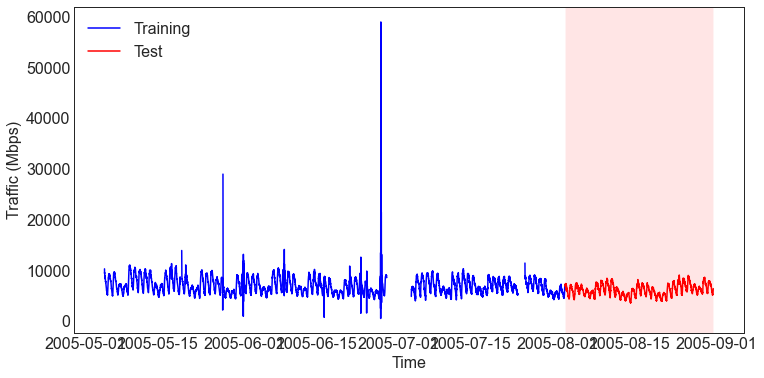

In [19]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

4.931113265982958


In [26]:
print(np.min(data.flatten()))

-0.003975552580138194


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

10769


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(10759, 10, 529)

In [32]:
y_data.shape

(10759, 1, 529)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(10759, 529)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

8606

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

6884

In [40]:
valid_length

1722

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(6884, 529, 10)

In [43]:
y_train.shape

(6884, 529)

In [44]:
X_valid.shape

(1722, 529, 10)

In [45]:
y_valid.shape

(1722, 529)

In [46]:
X_test.shape

(2153, 529, 10)

In [47]:
y_test.shape

(2153, 529)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(8606, 529, 10)

In [50]:
y.shape

(8606, 529)

In [51]:
splits

((#6884) [0,1,2,3,4,5,6,7,8,9...],
 (#1722) [6884,6885,6886,6887,6888,6889,6890,6891,6892,6893...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#8606) [(TSTensor(vars:529, len:10), tensor([0.0000e+00, 8.9423e-02, 3.7106e-01, 1.0264e-01, 7.2026e-02, 3.4304e-03,
        7.1890e-02, 1.2682e-02, 2.5281e-02, 9.1491e-03, 5.0183e-03, 1.2151e-01,
        0.0000e+00, 5.6280e-05, 1.8669e-02, 3.2046e-01, 3.0214e-02, 4.0630e-01,
        5.0114e-02, 6.6921e-02, 1.0054e-04, 0.0000e+00, 2.1455e-01, 0.0000e+00,
        7.3656e-01, 2.4451e-03, 1.4999e-02, 9.5933e-04, 1.4186e-01, 9.6139e-03,
        7.5581e-03, 5.6137e-01, 1.3439e-03, 7.8781e-03, 4.1034e-02, 1.0031e-02,
        5.2605e-03, 3.9400e-03, 5.2090e-02, 4.1799e-03, 2.3216e-02, 6.7784e-02,
        3.5897e-02, 1.7727e-01, 4.3577e-03, 5.7287e-01, 0.0000e+00, 7.6272e-02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0254e-04, 6.5089e-03, 1.7143e-03,
        1.1740e-01, 4.1891e-02, 7.4133e-03, 1.8199e-02, 1.3436e-02, 1.7860e-04,
        1.5109e-02, 1.5142e-02, 7.8321e-04, 1.5964e-02, 9.8029e-04, 2.2297e-02,
        8.7682e-02, 7.0101e-04, 8.7537e-03, 0.0000e+00, 2.1880e-01, 0.0000e+00,
  

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "d_model": hp.choice('d_model', [64, 128, 256]),
    "n_heads": hp.choice('n_heads', [8, 16, 32])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1aa4f7ddb08>,
 'lr': <hyperopt.pyll.base.Apply at 0x1aa40c51648>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1aa40c51508>,
 'patience': <hyperopt.pyll.base.Apply at 0x1aa40c51ec8>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1aa40c2c288>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x1aa40c2cb08>,
 'd_model': <hyperopt.pyll.base.Apply at 0x1aa40c2c848>,
 'n_heads': <hyperopt.pyll.base.Apply at 0x1aa4f9cbd48>}

In [55]:
# clear memory 
gc.collect()

40

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = TST
        k = {
            'n_layers': params['n_layers'],
            'd_model': params['d_model'],
            'n_heads': params['n_heads']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 20, 'lr': 0.01, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
  0%|                                                                          | 0/100 [00:02<?, ?trial/s, best loss=?]

No improvement since epoch 1: early stopping                                                                           
  0%|                                                                          | 0/100 [00:52<?, ?trial/s, best loss=?]

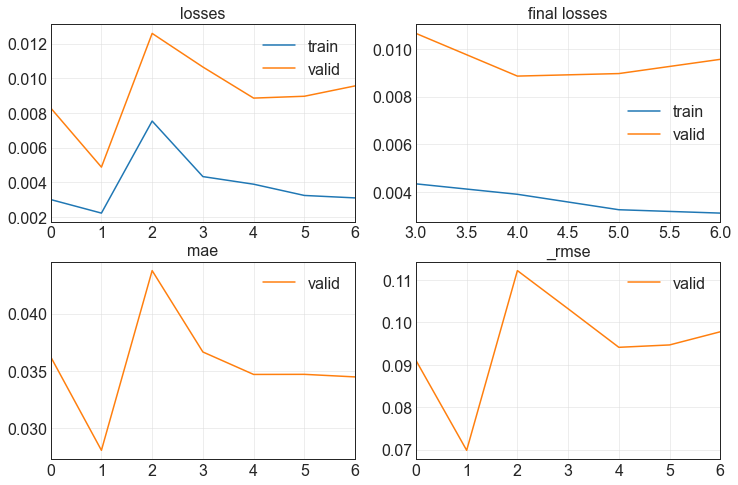

50.5771861076355                                                                                                       
[0.003105941228568554, 0.009564293548464775, 0.034460727125406265, 0.0977972000837326]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 64, 'epochs': 20, 'lr': 0.1, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
  1%|▍                                           | 1/100 [00:54<1:28:15, 53.49s/trial, best loss: 0.009564293548464775]

No improvement since epoch 14: early stopping                                                                          
  1%|▍                                           | 1/100 [01:25<1:28:15, 53.49s/trial, best loss: 0.009564293548464775]

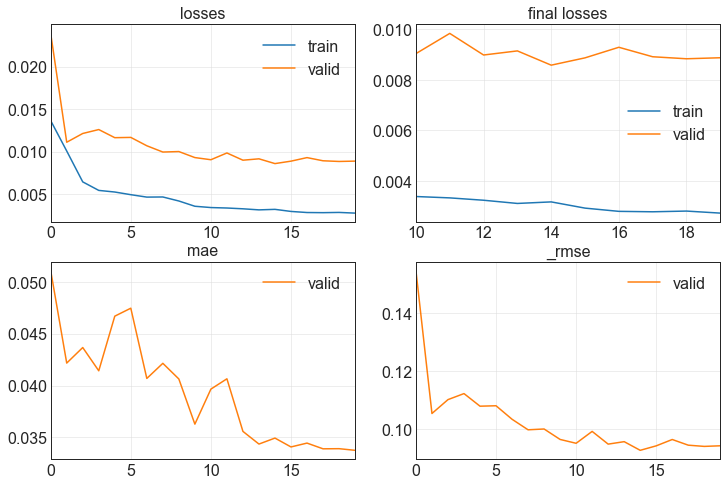

31.24360966682434                                                                                                      
[0.0027425354346632957, 0.00886816717684269, 0.03375623747706413, 0.094170942902565]                                   
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
  2%|▉                                            | 2/100 [01:27<1:17:09, 47.24s/trial, best loss: 0.00886816717684269]

No improvement since epoch 34: early stopping                                                                          
  2%|▉                                            | 2/100 [02:26<1:17:09, 47.24s/trial, best loss: 0.00886816717684269]

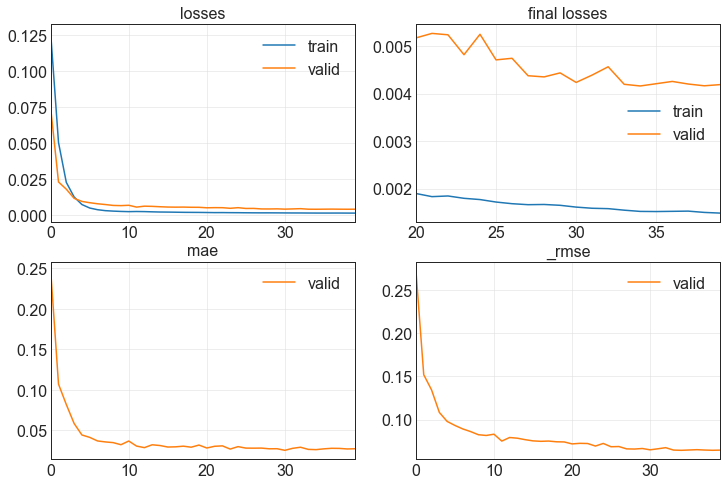

59.411808013916016                                                                                                     
[0.001483445637859404, 0.004188674967736006, 0.02732609026134014, 0.06471997499465942]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 100, 'lr': 0.1, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
  3%|█▎                                          | 3/100 [02:28<1:23:00, 51.34s/trial, best loss: 0.004188674967736006]

No improvement since epoch 12: early stopping                                                                          
  3%|█▎                                          | 3/100 [03:20<1:23:00, 51.34s/trial, best loss: 0.004188674967736006]

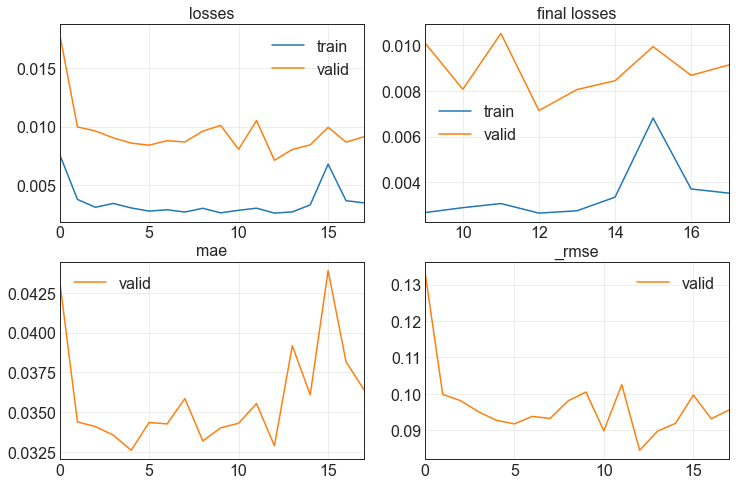

51.90260863304138                                                                                                      
[0.003520276863127947, 0.009136641398072243, 0.03641481325030327, 0.09558577835559845]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
  4%|█▊                                          | 4/100 [03:21<1:23:09, 51.97s/trial, best loss: 0.004188674967736006]

No improvement since epoch 4: early stopping                                                                           
  4%|█▊                                          | 4/100 [04:04<1:23:09, 51.97s/trial, best loss: 0.004188674967736006]

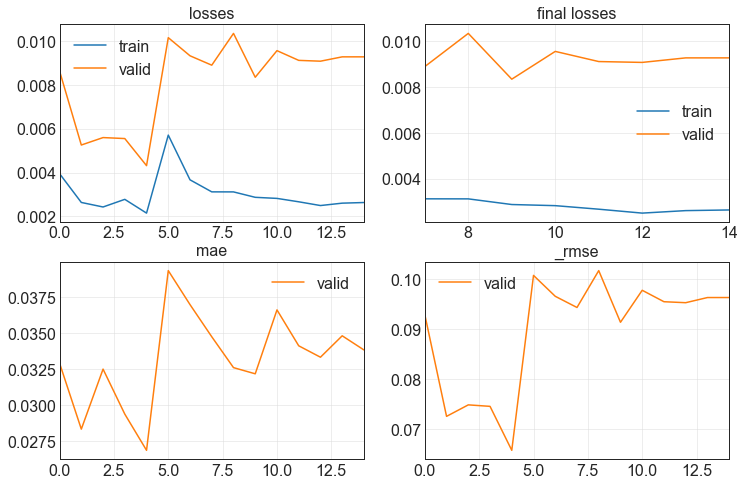

43.152032136917114                                                                                                     
[0.002635389333590865, 0.009274762123823166, 0.03382735326886177, 0.09630556404590607]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 100, 'lr': 0.01, 'n_heads': 8, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
  5%|██▏                                         | 5/100 [04:06<1:18:46, 49.76s/trial, best loss: 0.004188674967736006]

No improvement since epoch 9: early stopping                                                                           
  5%|██▏                                         | 5/100 [04:43<1:18:46, 49.76s/trial, best loss: 0.004188674967736006]

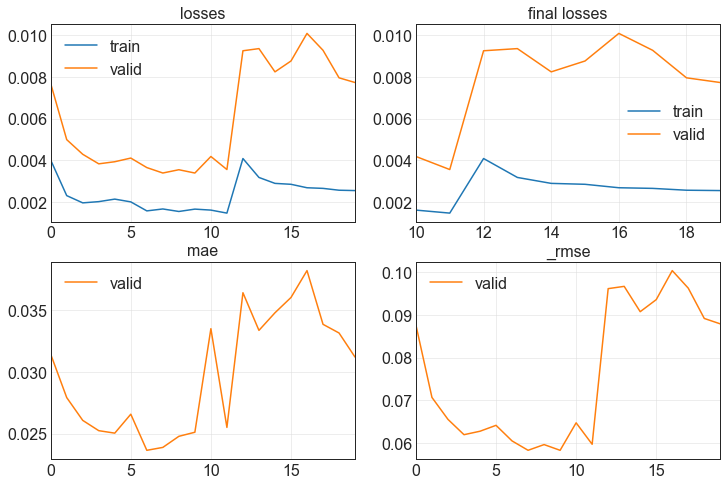

37.78310465812683                                                                                                      
[0.002552709309384227, 0.007725984323769808, 0.0312003493309021, 0.08789757639169693]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 100, 'lr': 0.01, 'n_heads': 16, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
  6%|██▋                                         | 6/100 [04:45<1:12:59, 46.59s/trial, best loss: 0.004188674967736006]

No improvement since epoch 9: early stopping                                                                           
  6%|██▋                                         | 6/100 [05:13<1:12:59, 46.59s/trial, best loss: 0.004188674967736006]

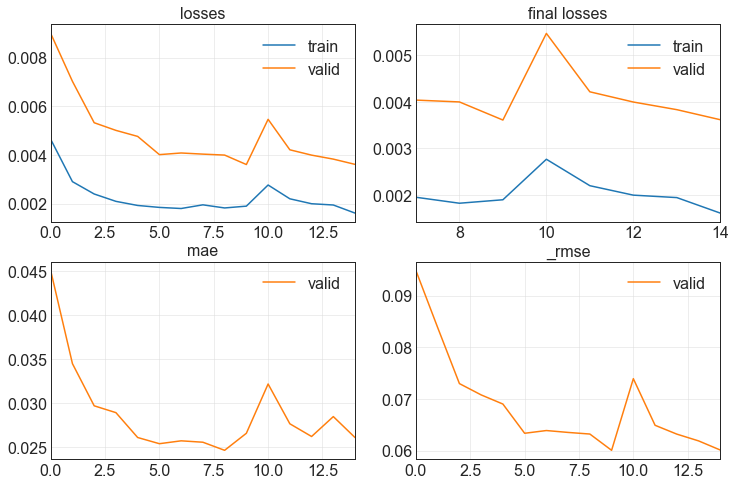

28.66334366798401                                                                                                      
[0.001611407846212387, 0.0036140969023108482, 0.02606254629790783, 0.06011736020445824]                                
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 50, 'lr': 0.01, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
  7%|███                                        | 7/100 [05:15<1:04:31, 41.63s/trial, best loss: 0.0036140969023108482]

No improvement since epoch 14: early stopping                                                                          
  7%|███                                        | 7/100 [05:26<1:04:31, 41.63s/trial, best loss: 0.0036140969023108482]

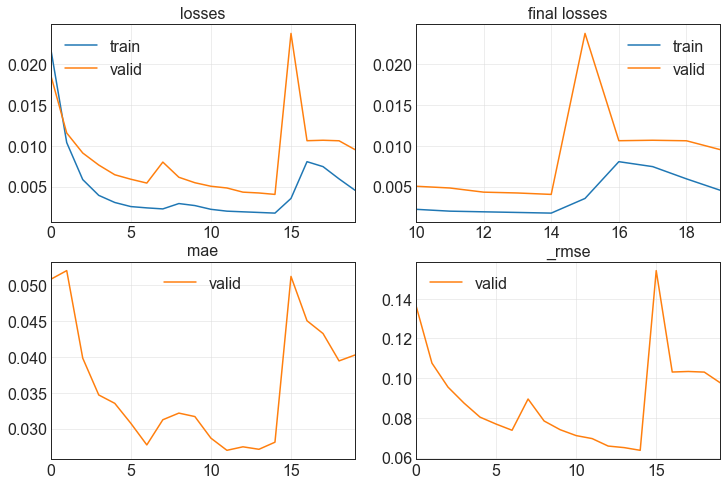

11.634167432785034                                                                                                     
[0.004557161591947079, 0.009536131285130978, 0.040290676057338715, 0.09765312075614929]                                
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 100, 'lr': 0.001, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
  8%|███▌                                         | 8/100 [05:28<50:41, 33.06s/trial, best loss: 0.0036140969023108482]

No improvement since epoch 54: early stopping                                                                          
  8%|███▌                                         | 8/100 [06:33<50:41, 33.06s/trial, best loss: 0.0036140969023108482]

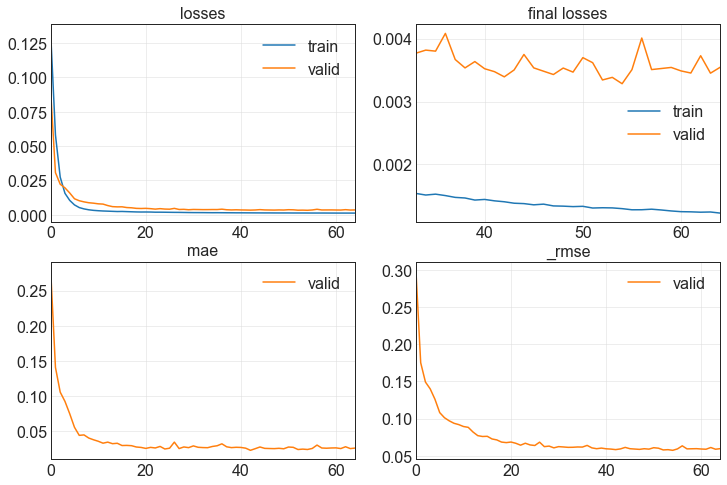

65.00099682807922                                                                                                      
[0.0012228399282321334, 0.0035466207191348076, 0.026277540251612663, 0.059553515166044235]                             
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
  9%|███▊                                       | 9/100 [06:35<1:05:18, 43.06s/trial, best loss: 0.0035466207191348076]

No improvement since epoch 14: early stopping                                                                          
  9%|███▊                                       | 9/100 [07:21<1:05:18, 43.06s/trial, best loss: 0.0035466207191348076]

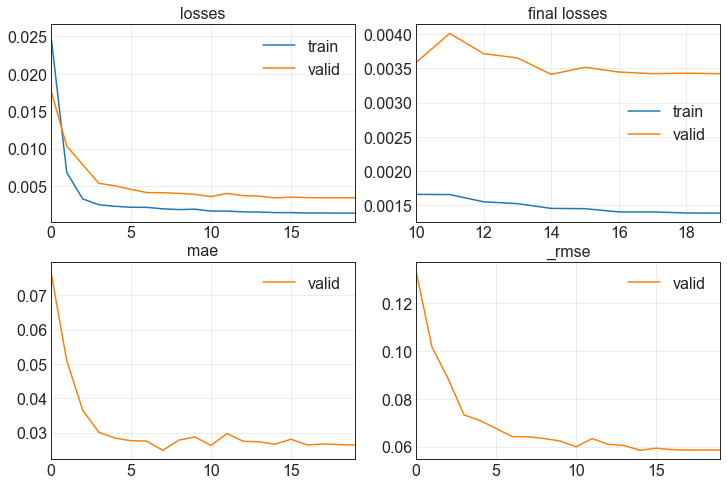

46.696674823760986                                                                                                     
[0.0013822715263813734, 0.003422376699745655, 0.026361992582678795, 0.05850107967853546]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 100, 'lr': 0.1, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 10%|████▎                                      | 10/100 [07:23<1:06:51, 44.58s/trial, best loss: 0.003422376699745655]

No improvement since epoch 19: early stopping                                                                          
 10%|████▎                                      | 10/100 [07:52<1:06:51, 44.58s/trial, best loss: 0.003422376699745655]

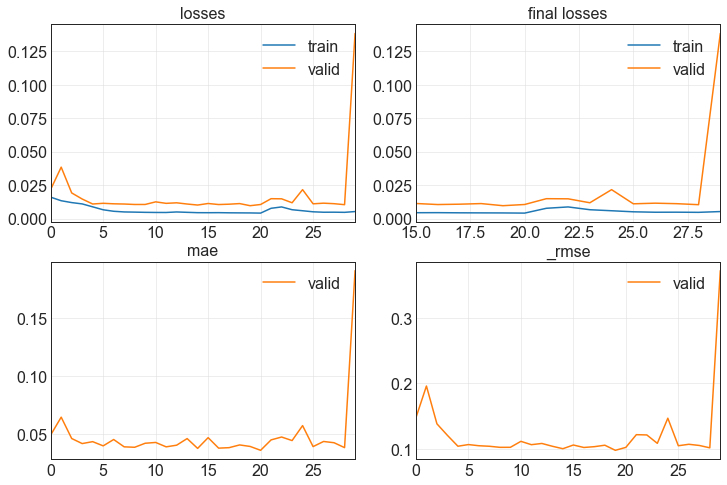

30.07908344268799                                                                                                      
[0.005191299133002758, 0.13839522004127502, 0.1907905638217926, 0.3720150887966156]                                    
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 100, 'lr': 0.01, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 11%|████▋                                      | 11/100 [07:54<1:00:18, 40.65s/trial, best loss: 0.003422376699745655]

No improvement since epoch 10: early stopping                                                                          
 11%|████▋                                      | 11/100 [08:26<1:00:18, 40.65s/trial, best loss: 0.003422376699745655]

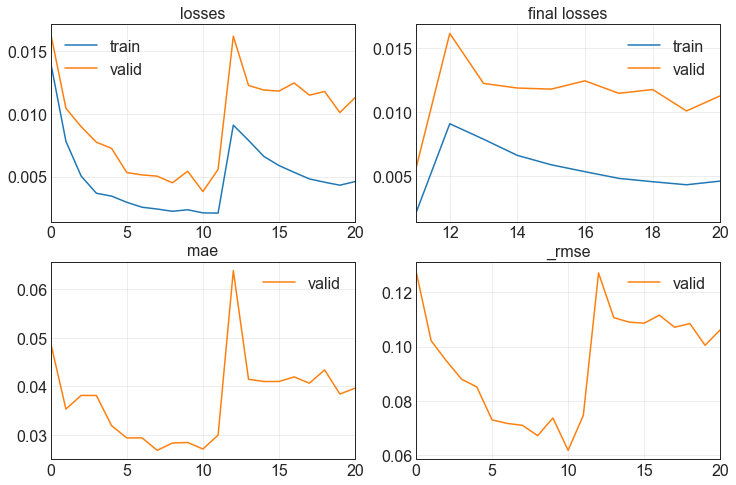

32.43245577812195                                                                                                      
[0.0046022613532841206, 0.011280409060418606, 0.03960537165403366, 0.10620926320552826]                                
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 50, 'lr': 0.1, 'n_heads': 8, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 12%|█████▍                                       | 12/100 [08:28<56:38, 38.62s/trial, best loss: 0.003422376699745655]

No improvement since epoch 7: early stopping                                                                           
 12%|█████▍                                       | 12/100 [09:37<56:38, 38.62s/trial, best loss: 0.003422376699745655]

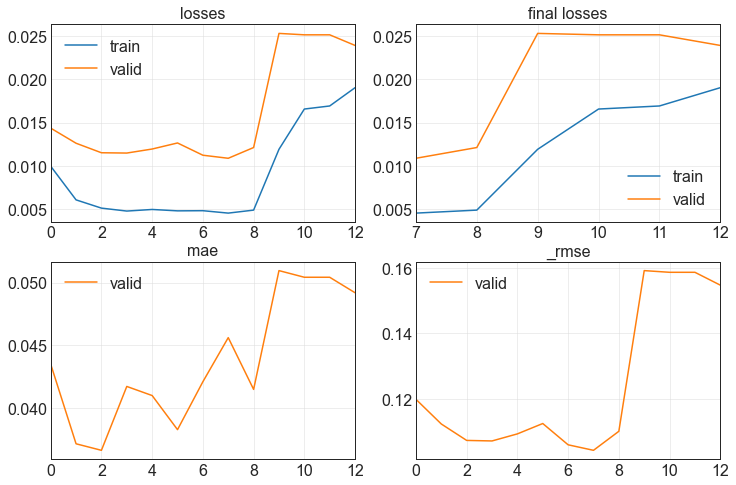

68.80615043640137                                                                                                      
[0.019048795104026794, 0.02394375018775463, 0.0491846427321434, 0.1547376811504364]                                    
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 128, 'epochs': 20, 'lr': 0.1, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 13%|█████▌                                     | 13/100 [09:38<1:09:44, 48.10s/trial, best loss: 0.003422376699745655]

No improvement since epoch 0: early stopping                                                                           
 13%|█████▌                                     | 13/100 [09:54<1:09:44, 48.10s/trial, best loss: 0.003422376699745655]

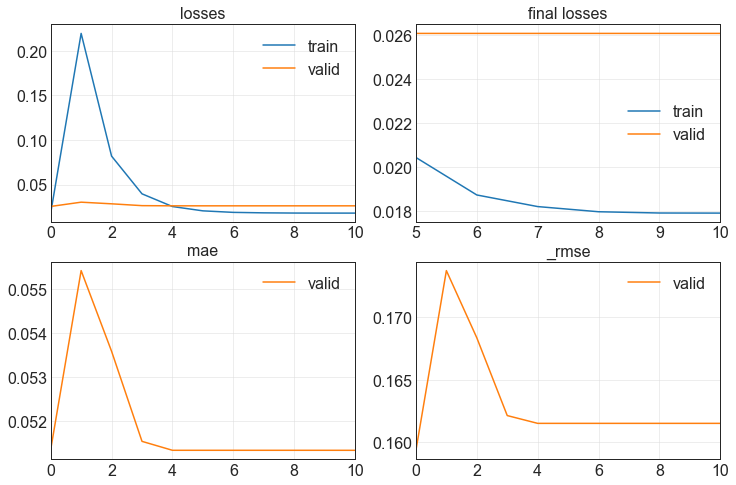

16.478668928146362                                                                                                     
[0.01791503094136715, 0.026085825636982918, 0.05132902413606644, 0.16151106357574463]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 100, 'lr': 0.01, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 14%|██████▎                                      | 14/100 [09:56<55:57, 39.04s/trial, best loss: 0.003422376699745655]

No improvement since epoch 9: early stopping                                                                           
 14%|██████▎                                      | 14/100 [10:50<55:57, 39.04s/trial, best loss: 0.003422376699745655]

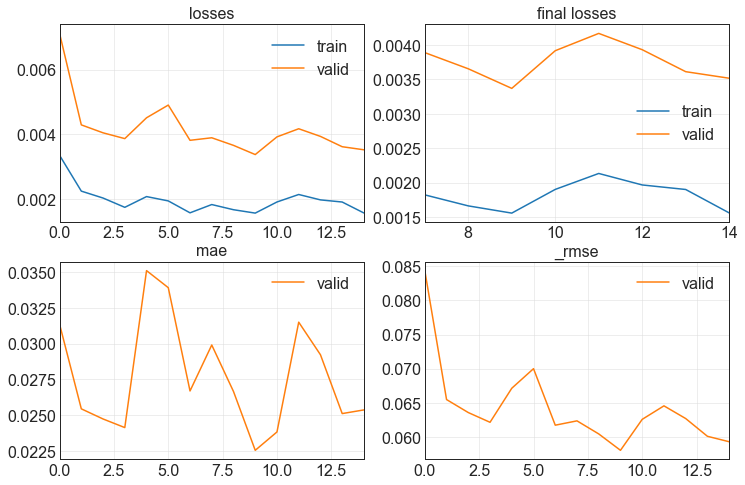

54.3358314037323                                                                                                       
[0.0015603717183694243, 0.0035163089632987976, 0.025372041389346123, 0.05929847061634064]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 15%|██████▍                                    | 15/100 [10:52<1:02:24, 44.05s/trial, best loss: 0.003422376699745655]

No improvement since epoch 20: early stopping                                                                          
 15%|██████▍                                    | 15/100 [13:08<1:02:24, 44.05s/trial, best loss: 0.003422376699745655]

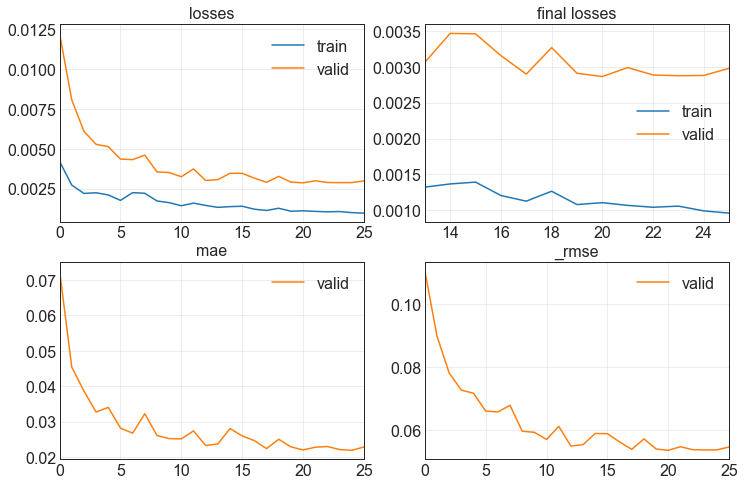

136.43616151809692                                                                                                     
[0.0009624357335269451, 0.002978815231472254, 0.022836461663246155, 0.054578520357608795]                              
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.1, 'n_heads': 8, 'n_layers': 4, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 16%|██████▉                                    | 16/100 [13:10<1:41:04, 72.19s/trial, best loss: 0.002978815231472254]

No improvement since epoch 1: early stopping                                                                           
 16%|██████▉                                    | 16/100 [13:25<1:41:04, 72.19s/trial, best loss: 0.002978815231472254]

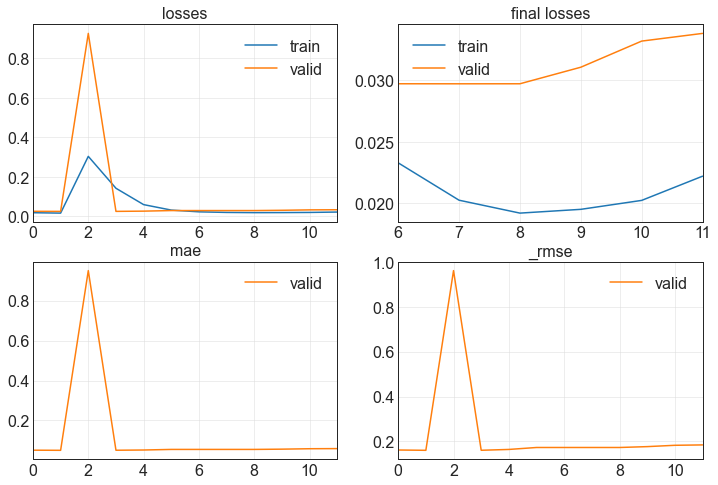

15.975212574005127                                                                                                     
[0.022212577983736992, 0.033828601241111755, 0.059072211384773254, 0.18392552435398102]                                
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 20, 'lr': 0.1, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 17%|███████▎                                   | 17/100 [13:27<1:17:07, 55.75s/trial, best loss: 0.002978815231472254]

No improvement since epoch 3: early stopping                                                                           
 17%|███████▎                                   | 17/100 [13:52<1:17:07, 55.75s/trial, best loss: 0.002978815231472254]

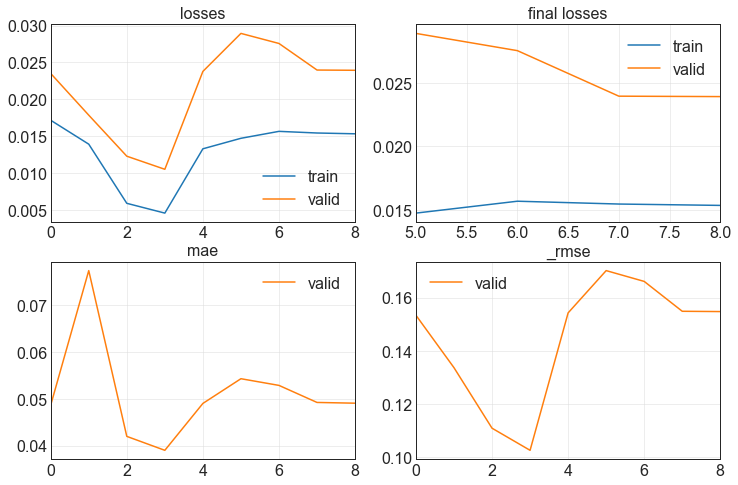

25.545017957687378                                                                                                     
[0.015343068167567253, 0.02394242025911808, 0.049061987549066544, 0.15473338961601257]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 128, 'epochs': 100, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 18%|███████▋                                   | 18/100 [13:54<1:04:22, 47.11s/trial, best loss: 0.002978815231472254]

No improvement since epoch 21: early stopping                                                                          
 18%|███████▋                                   | 18/100 [15:12<1:04:22, 47.11s/trial, best loss: 0.002978815231472254]

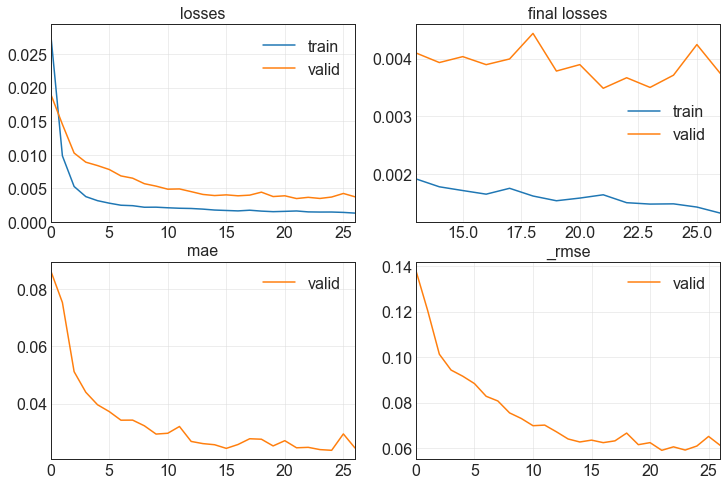

77.91927194595337                                                                                                      
[0.001319444039836526, 0.0037429349031299353, 0.024555038660764694, 0.06117952987551689]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 100, 'lr': 0.001, 'n_heads': 16, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 19%|████████▏                                  | 19/100 [15:14<1:16:39, 56.78s/trial, best loss: 0.002978815231472254]

No improvement since epoch 17: early stopping                                                                          
 19%|████████▏                                  | 19/100 [15:59<1:16:39, 56.78s/trial, best loss: 0.002978815231472254]

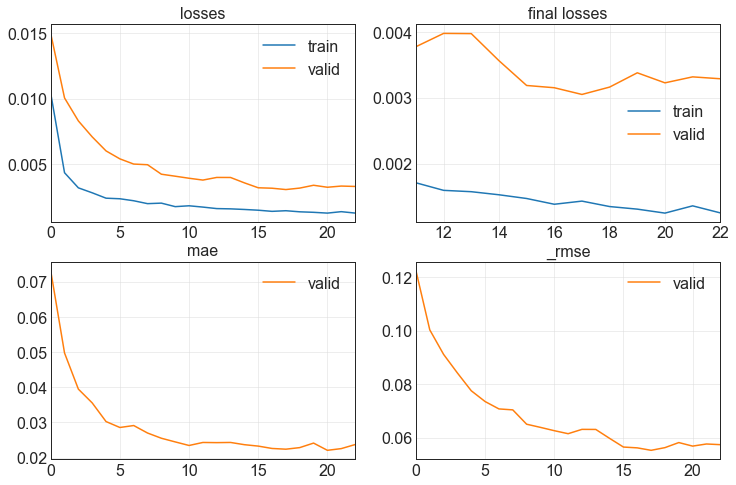

46.175697326660156                                                                                                     
[0.0012500688899308443, 0.0032866415567696095, 0.023698516190052032, 0.05732923746109009]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 20%|████████▌                                  | 20/100 [16:01<1:12:01, 54.02s/trial, best loss: 0.002978815231472254]

No improvement since epoch 24: early stopping                                                                          
 20%|████████▌                                  | 20/100 [17:52<1:12:01, 54.02s/trial, best loss: 0.002978815231472254]

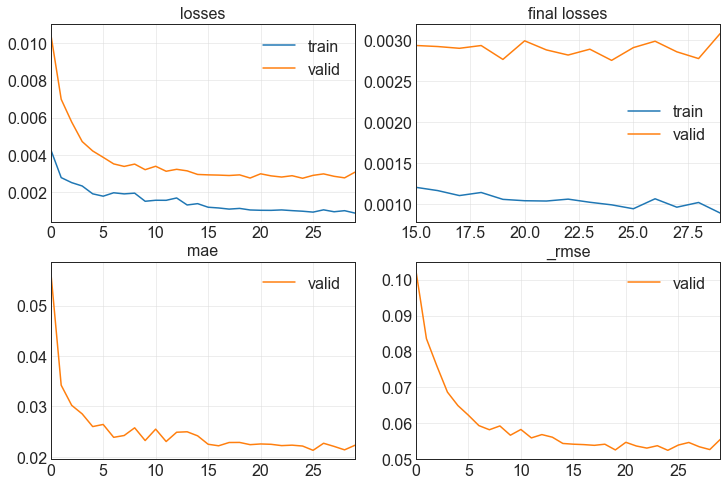

110.89671468734741                                                                                                     
[0.0008870222372934222, 0.0030830614268779755, 0.022304514423012733, 0.05552532896399498]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 21%|█████████                                  | 21/100 [17:54<1:34:10, 71.52s/trial, best loss: 0.002978815231472254]

No improvement since epoch 25: early stopping                                                                          
 21%|█████████                                  | 21/100 [20:44<1:34:10, 71.52s/trial, best loss: 0.002978815231472254]

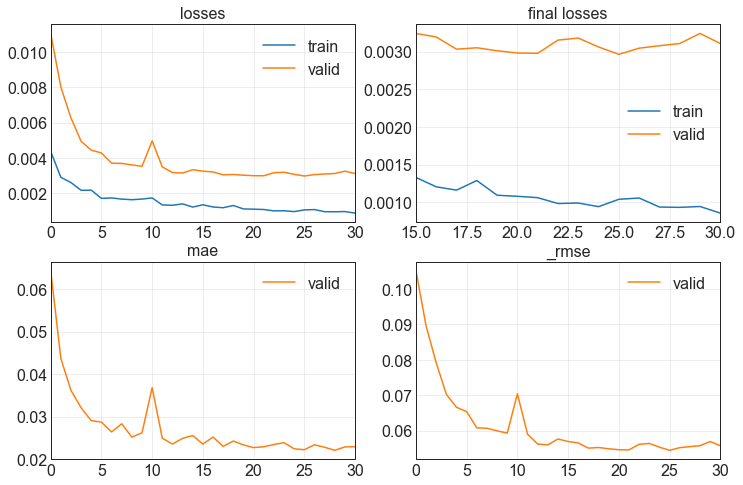

170.57201552391052                                                                                                     
[0.0008580461144447327, 0.0031077282037585974, 0.022939227521419525, 0.055747002363204956]                             
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 22%|█████████▏                                | 22/100 [20:46<2:12:10, 101.67s/trial, best loss: 0.002978815231472254]

No improvement since epoch 10: early stopping                                                                          
 22%|█████████▏                                | 22/100 [21:45<2:12:10, 101.67s/trial, best loss: 0.002978815231472254]

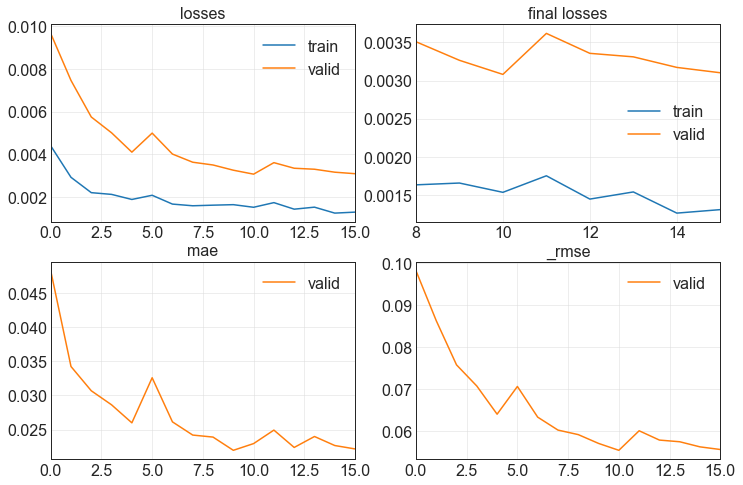

59.83665442466736                                                                                                      
[0.0013065949315205216, 0.003102006856352091, 0.022156495600938797, 0.05569566413760185]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 23%|█████████▉                                 | 23/100 [21:47<1:54:56, 89.56s/trial, best loss: 0.002978815231472254]

No improvement since epoch 23: early stopping                                                                          
 23%|█████████▉                                 | 23/100 [24:26<1:54:56, 89.56s/trial, best loss: 0.002978815231472254]

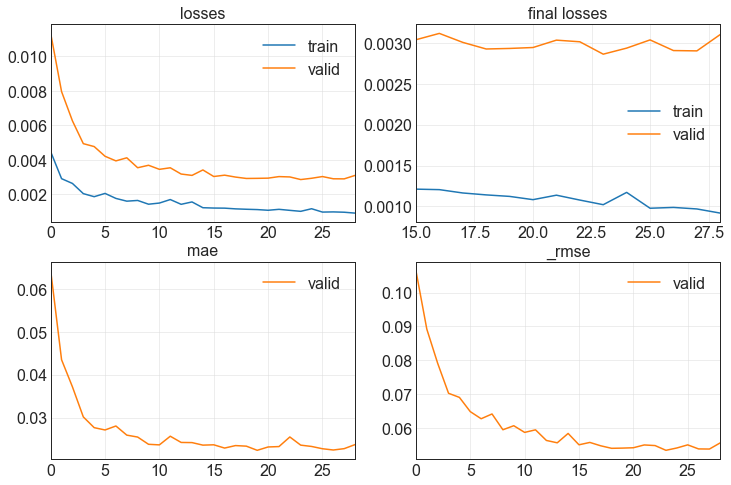

159.6883668899536                                                                                                      
[0.0009179239859804511, 0.0031036981381475925, 0.02369000017642975, 0.055710844695568085]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 24%|██████████                                | 24/100 [24:28<2:20:37, 111.02s/trial, best loss: 0.002978815231472254]

No improvement since epoch 22: early stopping                                                                          
 24%|██████████                                | 24/100 [28:35<2:20:37, 111.02s/trial, best loss: 0.002978815231472254]

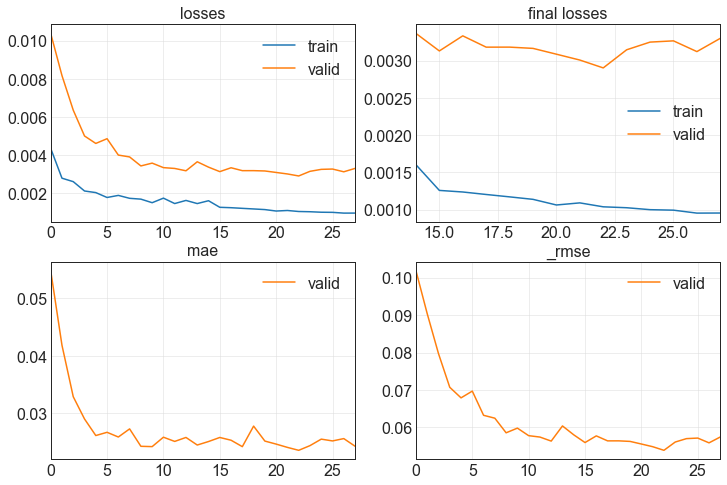

247.23279070854187                                                                                                     
[0.0009533588890917599, 0.0032983364071696997, 0.02430792525410652, 0.05743115022778511]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 25%|██████████▌                               | 25/100 [28:37<3:10:25, 152.34s/trial, best loss: 0.002978815231472254]

No improvement since epoch 8: early stopping                                                                           
 25%|██████████▌                               | 25/100 [29:54<3:10:25, 152.34s/trial, best loss: 0.002978815231472254]

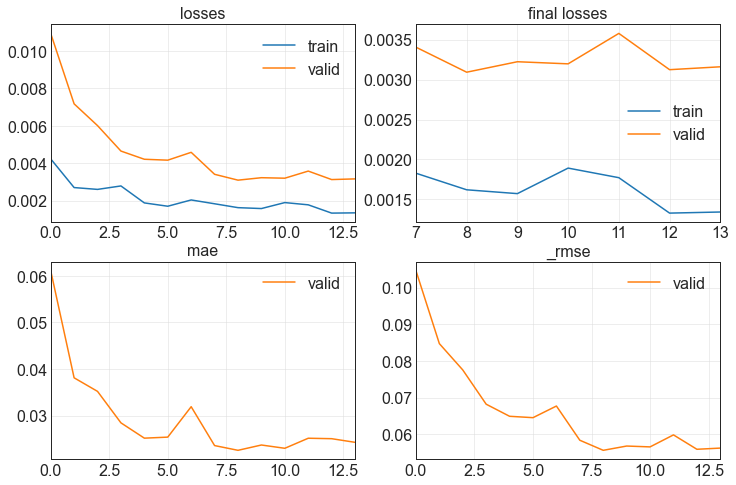

77.8353853225708                                                                                                       
[0.0013423014897853136, 0.0031600696966052055, 0.024251174181699753, 0.05621449649333954]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 26%|██████████▉                               | 26/100 [29:56<2:40:52, 130.43s/trial, best loss: 0.002978815231472254]

No improvement since epoch 12: early stopping                                                                          
 26%|██████████▉                               | 26/100 [31:03<2:40:52, 130.43s/trial, best loss: 0.002978815231472254]

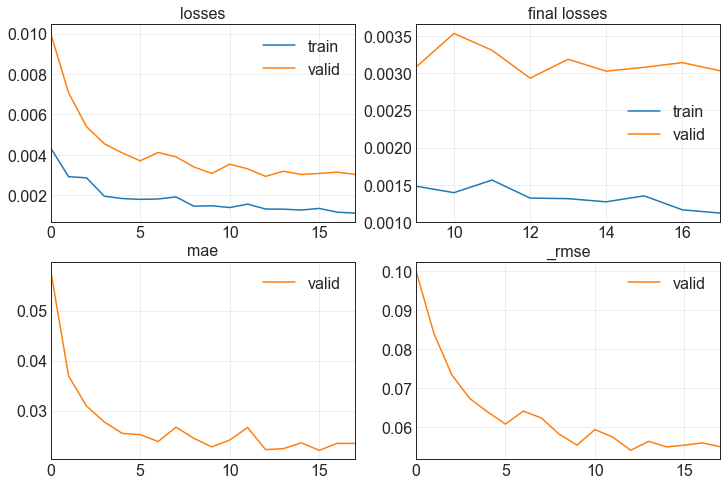

67.03836011886597                                                                                                      
[0.0011183999013155699, 0.0030339357908815145, 0.023428283631801605, 0.05508117750287056]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 27%|███████████▎                              | 27/100 [31:05<2:16:05, 111.85s/trial, best loss: 0.002978815231472254]

No improvement since epoch 18: early stopping                                                                          
 27%|███████████▎                              | 27/100 [33:10<2:16:05, 111.85s/trial, best loss: 0.002978815231472254]

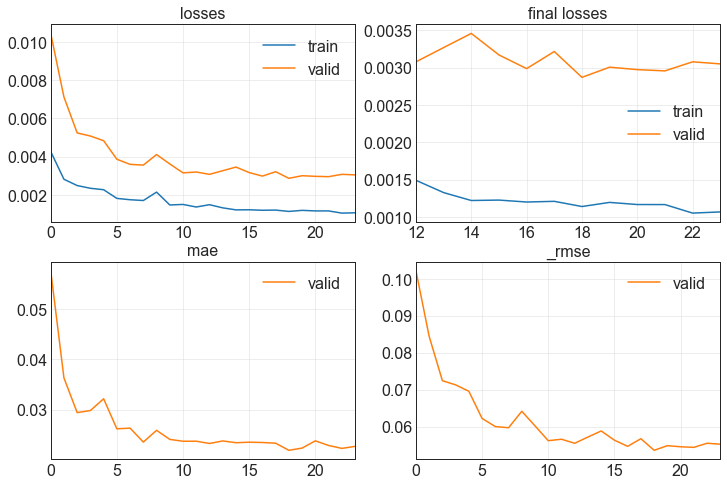

125.78685760498047                                                                                                     
[0.001066220342181623, 0.003048472572118044, 0.022710736840963364, 0.055212970823049545]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 28%|███████████▊                              | 28/100 [33:12<2:19:45, 116.46s/trial, best loss: 0.002978815231472254]

No improvement since epoch 20: early stopping                                                                          
 28%|███████████▊                              | 28/100 [36:10<2:19:45, 116.46s/trial, best loss: 0.002978815231472254]

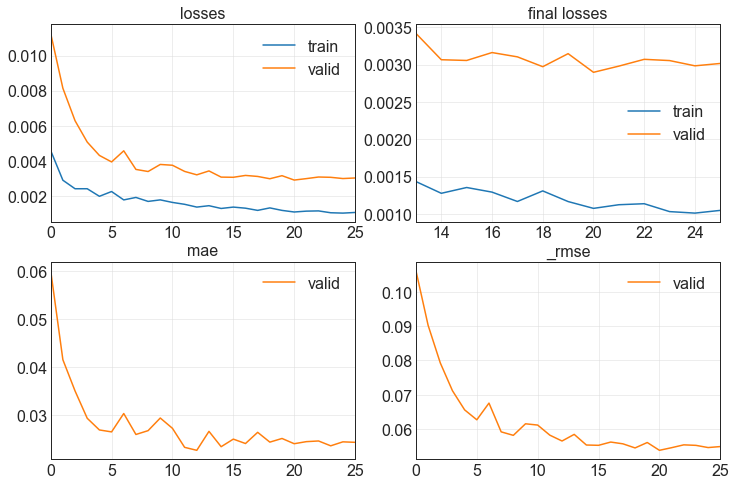

179.17770218849182                                                                                                     
[0.0010483086807653308, 0.0030166972428560257, 0.024236945435404778, 0.05492446571588516]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 29%|████████████▏                             | 29/100 [36:12<2:40:34, 135.70s/trial, best loss: 0.002978815231472254]

No improvement since epoch 21: early stopping                                                                          
 29%|████████████▏                             | 29/100 [39:28<2:40:34, 135.70s/trial, best loss: 0.002978815231472254]

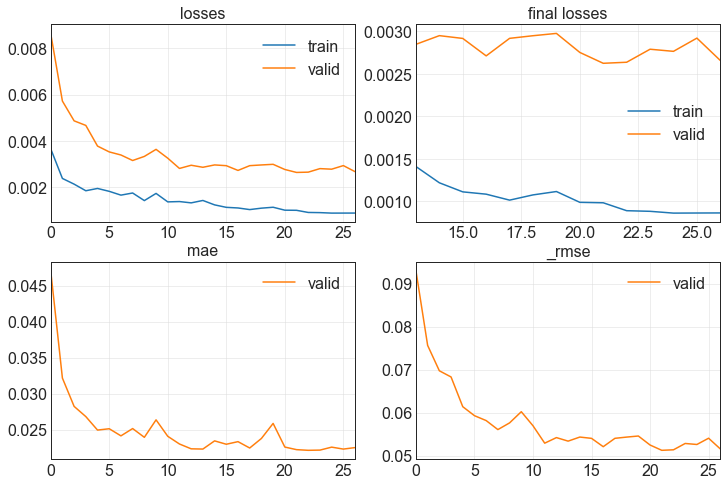

195.85279488563538                                                                                                     
[0.0008637701394036412, 0.0026584535371512175, 0.02249895967543125, 0.05156019330024719]                               
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 30%|████████████▎                            | 30/100 [39:30<2:59:52, 154.18s/trial, best loss: 0.0026584535371512175]

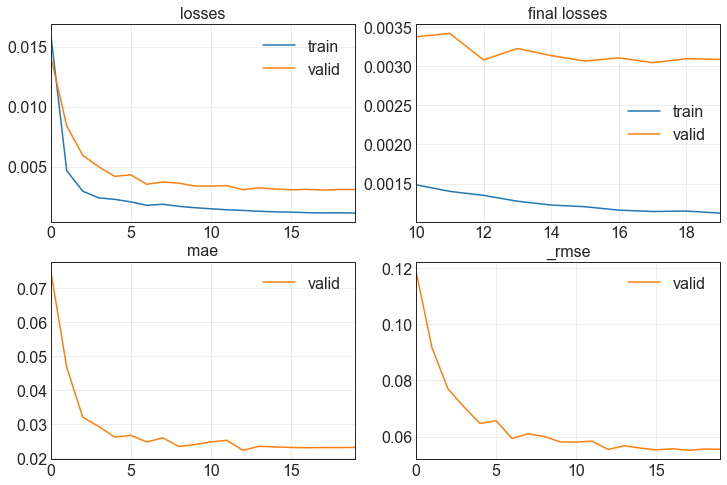

37.15962028503418                                                                                                      
[0.0011242310283705592, 0.0030844982247799635, 0.02304326556622982, 0.05553825944662094]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 31%|████████████▋                            | 31/100 [40:08<2:17:26, 119.51s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 21: early stopping                                                                          
 31%|████████████▋                            | 31/100 [43:16<2:17:26, 119.51s/trial, best loss: 0.0026584535371512175]

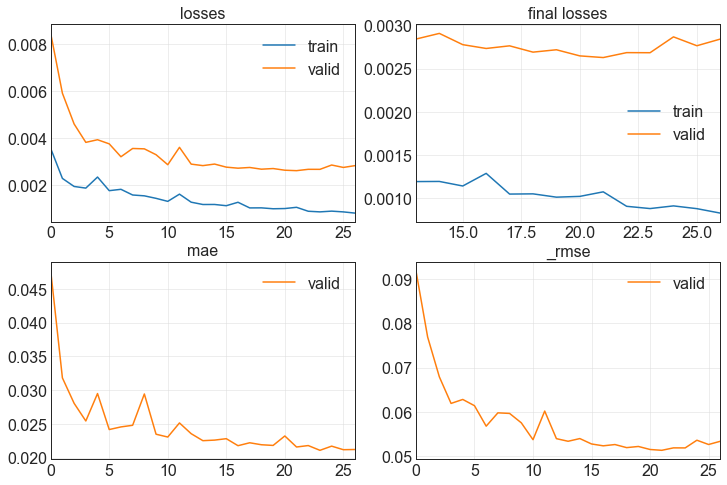

188.6292688846588                                                                                                      
[0.0008256045402958989, 0.0028419732116162777, 0.021193930879235268, 0.05331015959382057]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 32%|█████████████                            | 32/100 [43:18<2:39:26, 140.68s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 18: early stopping                                                                          
 32%|█████████████                            | 32/100 [46:06<2:39:26, 140.68s/trial, best loss: 0.0026584535371512175]

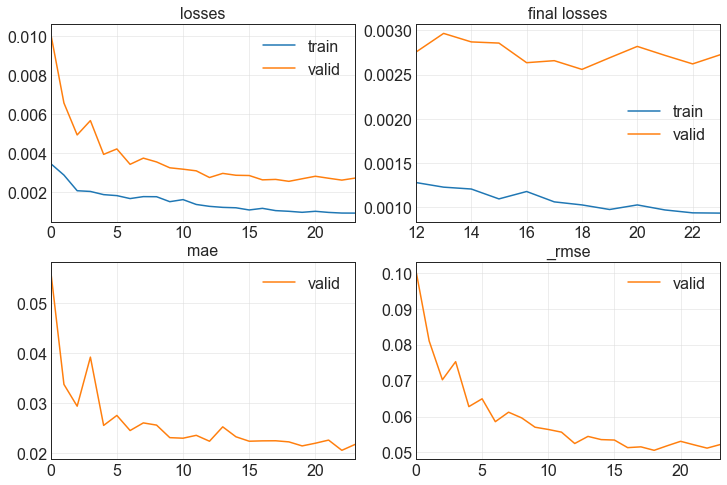

167.8279311656952                                                                                                      
[0.0009352542692795396, 0.0027251350693404675, 0.02166740782558918, 0.052202820777893066]                              
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 33%|█████████████▌                           | 33/100 [46:08<2:46:39, 149.25s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 11: early stopping                                                                          
 33%|█████████████▌                           | 33/100 [46:39<2:46:39, 149.25s/trial, best loss: 0.0026584535371512175]

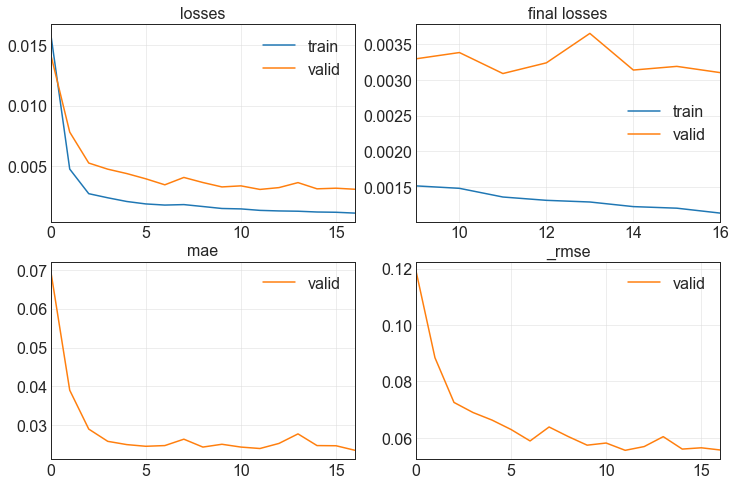

31.59553360939026                                                                                                      
[0.00113672052975744, 0.003102207789197564, 0.023599835112690926, 0.05569746345281601]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 34%|█████████████▉                           | 34/100 [46:41<2:05:50, 114.39s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 25: early stopping                                                                          
 34%|█████████████▉                           | 34/100 [50:52<2:05:50, 114.39s/trial, best loss: 0.0026584535371512175]

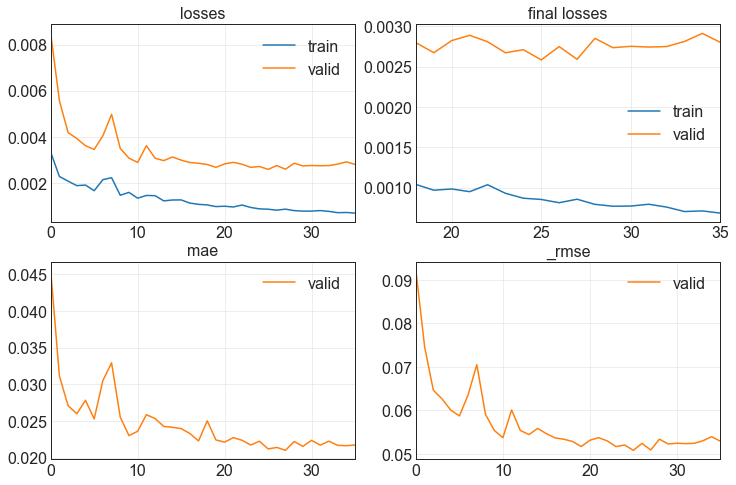

251.57144975662231                                                                                                     
[0.000684232683852315, 0.0028000741731375456, 0.02172163501381874, 0.05291572958230972]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 35%|██████████████▎                          | 35/100 [50:54<2:48:57, 155.97s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 3: early stopping                                                                           
 35%|██████████████▎                          | 35/100 [51:56<2:48:57, 155.97s/trial, best loss: 0.0026584535371512175]

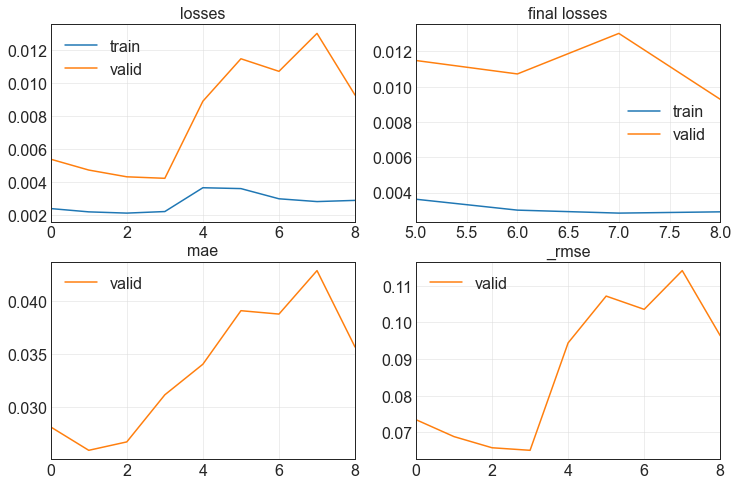

63.134589433670044                                                                                                     
[0.00290573388338089, 0.009284616447985172, 0.03564148023724556, 0.09635671228170395]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 36%|██████████████▊                          | 36/100 [51:58<2:17:07, 128.55s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 15: early stopping                                                                          
 36%|██████████████▊                          | 36/100 [54:27<2:17:07, 128.55s/trial, best loss: 0.0026584535371512175]

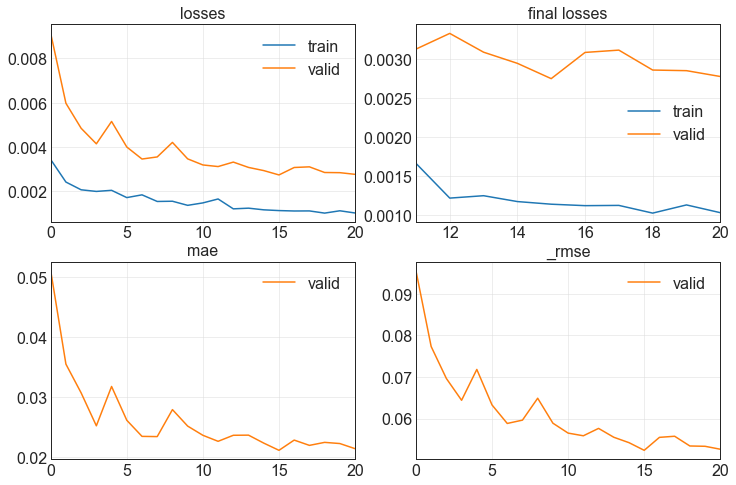

148.84307861328125                                                                                                     
[0.0010290170321241021, 0.0027732986491173506, 0.0214413870126009, 0.052662111818790436]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.1, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 37%|███████████████▏                         | 37/100 [54:29<2:21:48, 135.06s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 4: early stopping                                                                           
 37%|███████████████▏                         | 37/100 [56:14<2:21:48, 135.06s/trial, best loss: 0.0026584535371512175]

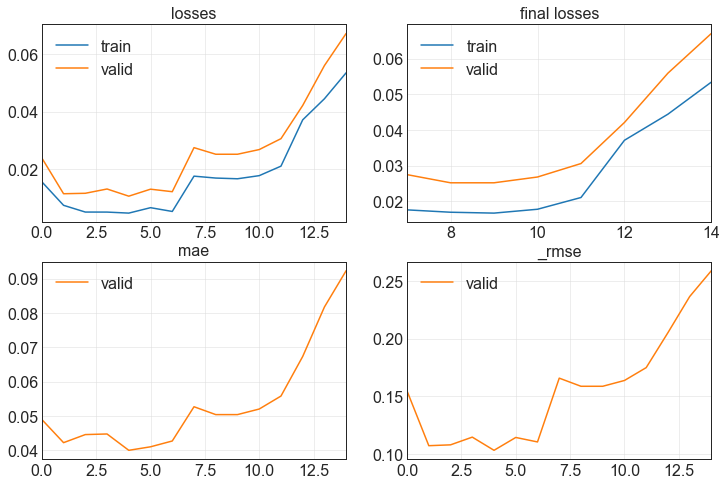

105.7828598022461                                                                                                      
[0.053453199565410614, 0.06710108369588852, 0.09234736114740372, 0.2590387463569641]                                   
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.01, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 38%|███████████████▌                         | 38/100 [56:16<2:10:58, 126.75s/trial, best loss: 0.0026584535371512175]

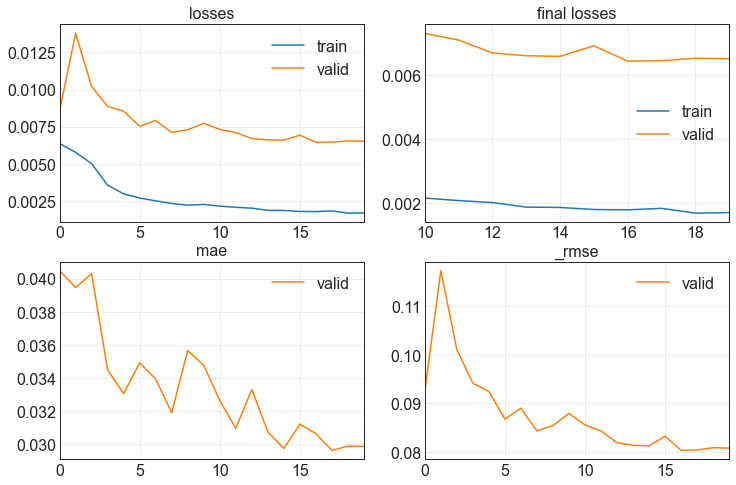

38.20620107650757                                                                                                      
[0.001698790118098259, 0.006523002404719591, 0.029866687953472137, 0.08076509088277817]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 39%|███████████████▉                         | 39/100 [56:56<1:42:17, 100.62s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 13: early stopping                                                                          
 39%|███████████████▉                         | 39/100 [59:47<1:42:17, 100.62s/trial, best loss: 0.0026584535371512175]

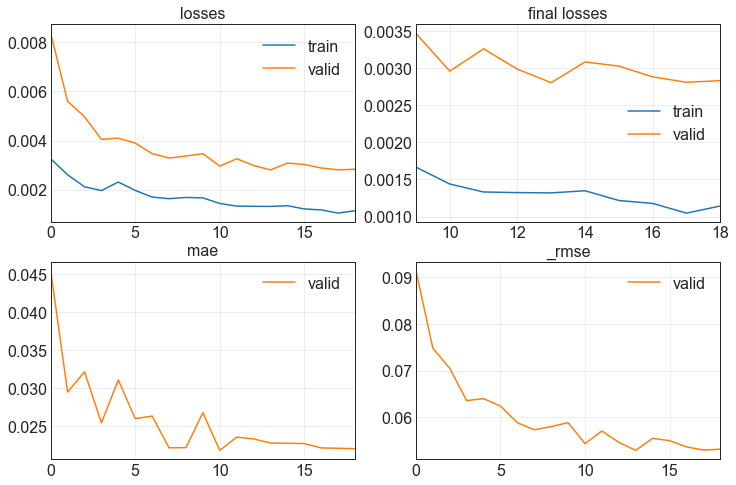

171.85462164878845                                                                                                     
[0.0011427713325247169, 0.0028304937295615673, 0.02204013802111149, 0.05320239067077637]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 40%|████████████████▍                        | 40/100 [59:49<2:02:26, 122.44s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 4: early stopping                                                                           
 40%|███████████████▌                       | 40/100 [1:00:44<2:02:26, 122.44s/trial, best loss: 0.0026584535371512175]

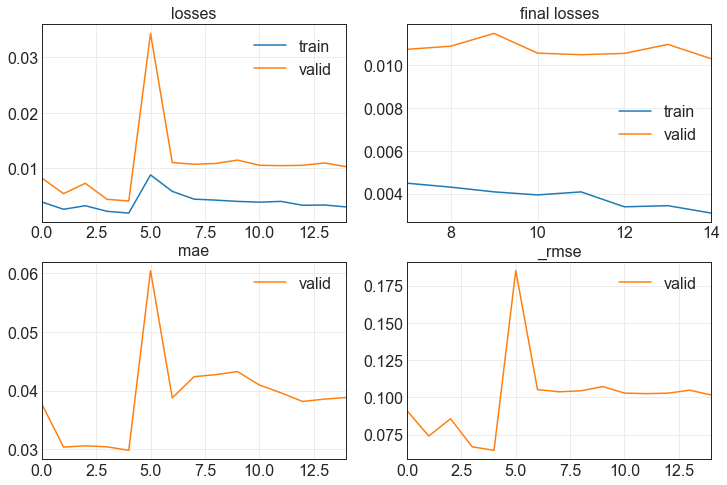

55.497660636901855                                                                                                     
[0.0030882670544087887, 0.010306661948561668, 0.038829732686281204, 0.10152173787355423]                               
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 41%|███████████████▉                       | 41/100 [1:00:46<1:41:06, 102.83s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 9: early stopping                                                                           
 41%|███████████████▉                       | 41/100 [1:01:15<1:41:06, 102.83s/trial, best loss: 0.0026584535371512175]

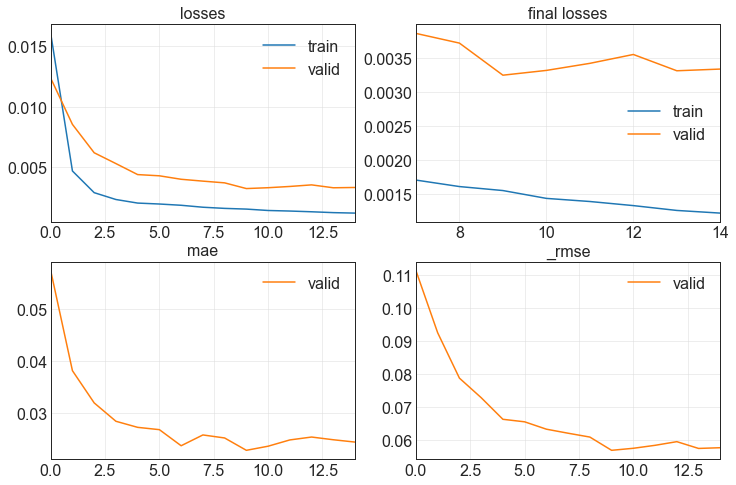

29.221668481826782                                                                                                     
[0.0012216733302921057, 0.0033414300996810198, 0.024356720969080925, 0.057805102318525314]                             
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 50, 'lr': 0.1, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 42%|████████████████▊                       | 42/100 [1:01:17<1:18:28, 81.19s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 8: early stopping                                                                           
 42%|████████████████▊                       | 42/100 [1:01:32<1:18:28, 81.19s/trial, best loss: 0.0026584535371512175]

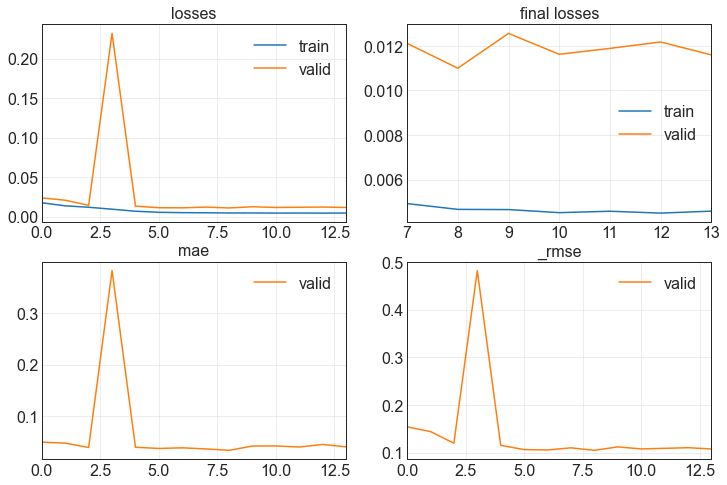

15.479172706604004                                                                                                     
[0.004581706132739782, 0.011596162803471088, 0.04102378711104393, 0.10768548399209976]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 43%|██████████████████                        | 43/100 [1:01:34<58:49, 61.92s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 30: early stopping                                                                          
 43%|██████████████████                        | 43/100 [1:08:50<58:49, 61.92s/trial, best loss: 0.0026584535371512175]

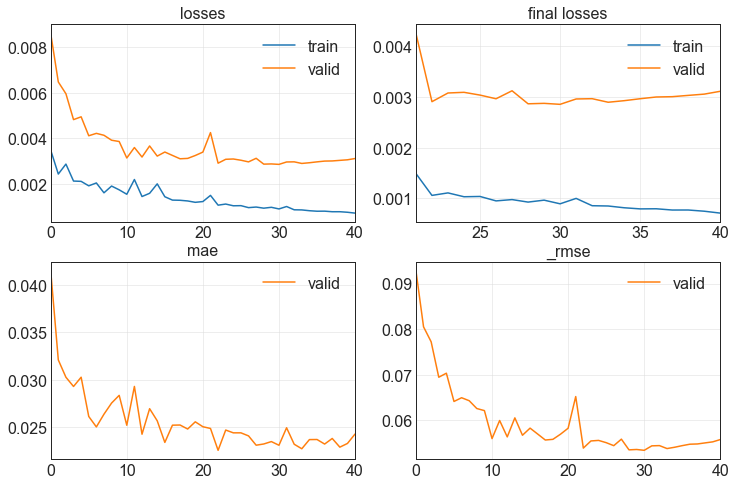

436.93137526512146                                                                                                     
[0.0007108119316399097, 0.0031131284777075052, 0.02431418001651764, 0.05579540878534317]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 44%|█████████████████▏                     | 44/100 [1:08:52<2:43:12, 174.87s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 5: early stopping                                                                           
 44%|█████████████████▏                     | 44/100 [1:09:41<2:43:12, 174.87s/trial, best loss: 0.0026584535371512175]

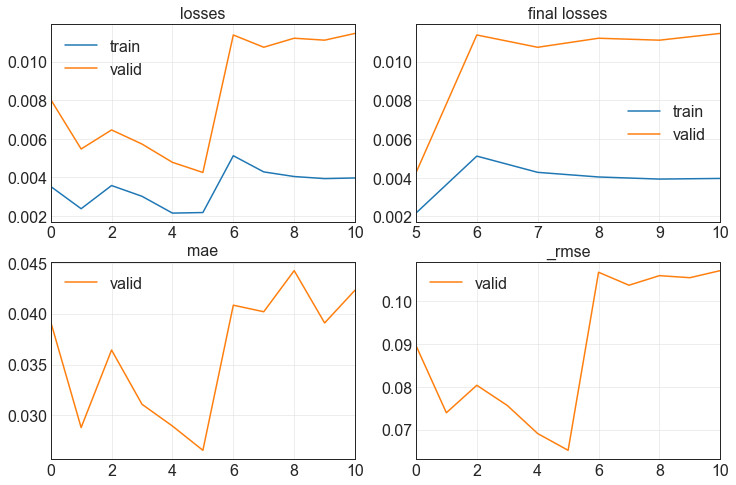

49.55937361717224                                                                                                      
[0.003965276293456554, 0.011463282629847527, 0.04231855273246765, 0.10706672817468643]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 20, 'lr': 0.1, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 45%|█████████████████▌                     | 45/100 [1:09:43<2:06:14, 137.72s/trial, best loss: 0.0026584535371512175]

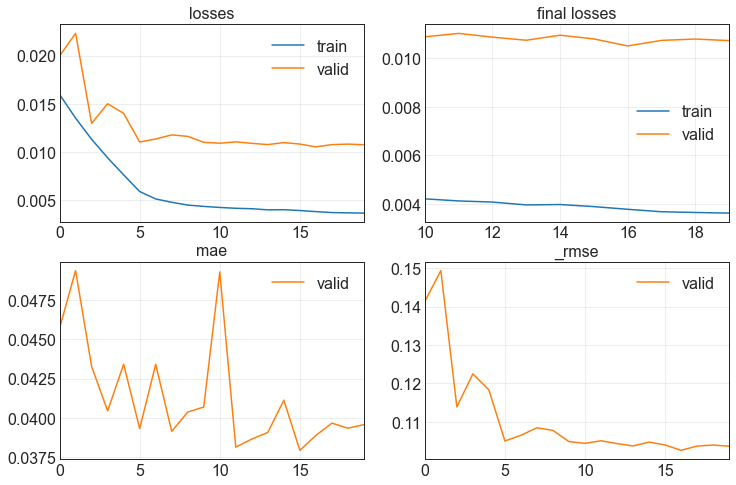

20.89549732208252                                                                                                      
[0.0036199616733938456, 0.010735469870269299, 0.039575621485710144, 0.10361211001873016]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 46%|█████████████████▉                     | 46/100 [1:10:05<1:32:47, 103.10s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 16: early stopping                                                                          
 46%|█████████████████▉                     | 46/100 [1:12:44<1:32:47, 103.10s/trial, best loss: 0.0026584535371512175]

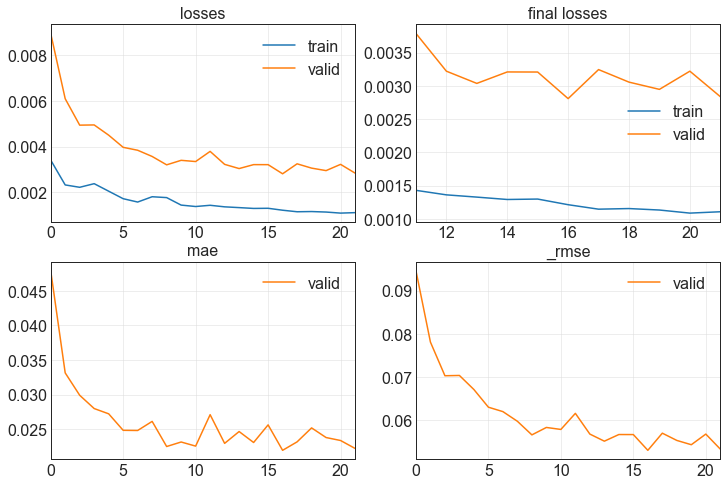

159.44259905815125                                                                                                     
[0.0011050286702811718, 0.002836973173543811, 0.022240400314331055, 0.053263239562511444]                              
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 47%|██████████████████▎                    | 47/100 [1:12:46<1:46:23, 120.43s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 4: early stopping                                                                           
 47%|██████████████████▎                    | 47/100 [1:13:15<1:46:23, 120.43s/trial, best loss: 0.0026584535371512175]

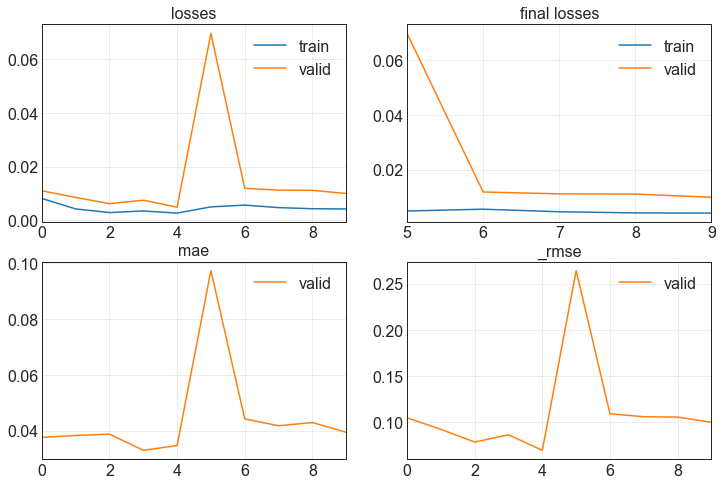

28.9252872467041                                                                                                       
[0.004151658155024052, 0.009928717277944088, 0.03940293937921524, 0.09964295476675034]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 50, 'lr': 0.001, 'n_heads': 8, 'n_layers': 4, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 48%|███████████████████▏                    | 48/100 [1:13:17<1:20:58, 93.43s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 27: early stopping                                                                          
 48%|███████████████████▏                    | 48/100 [1:16:11<1:20:58, 93.43s/trial, best loss: 0.0026584535371512175]

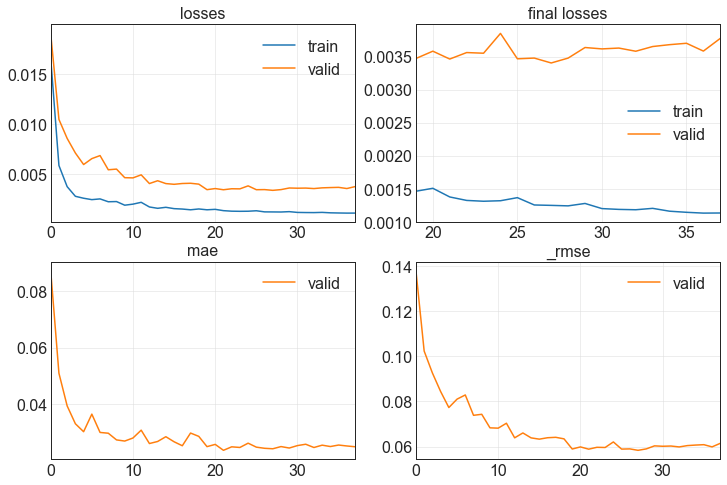

175.02326655387878                                                                                                     
[0.0011329026892781258, 0.00377450929954648, 0.02475992776453495, 0.061437033116817474]                                
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 100, 'lr': 0.1, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 49%|███████████████████                    | 49/100 [1:16:13<1:40:35, 118.34s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 10: early stopping                                                                          
 49%|███████████████████                    | 49/100 [1:16:31<1:40:35, 118.34s/trial, best loss: 0.0026584535371512175]

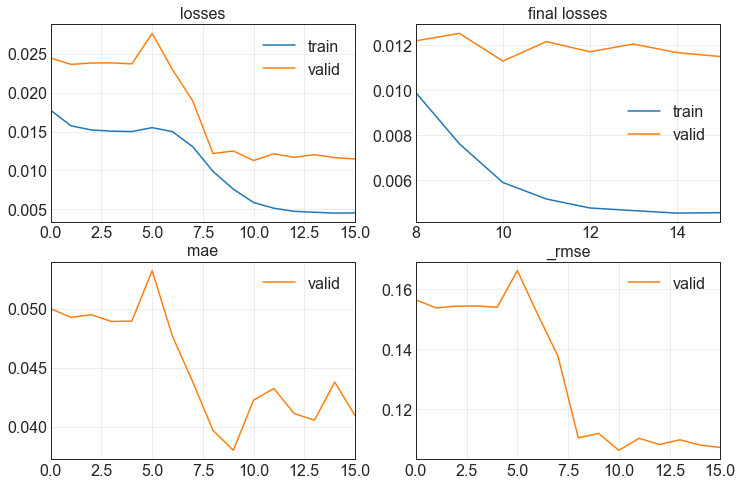

17.984001874923706                                                                                                     
[0.0045468974858522415, 0.011478033848106861, 0.04092875123023987, 0.1071355864405632]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 50%|████████████████████                    | 50/100 [1:16:33<1:13:55, 88.71s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 18: early stopping                                                                          
 50%|████████████████████                    | 50/100 [1:20:50<1:13:55, 88.71s/trial, best loss: 0.0026584535371512175]

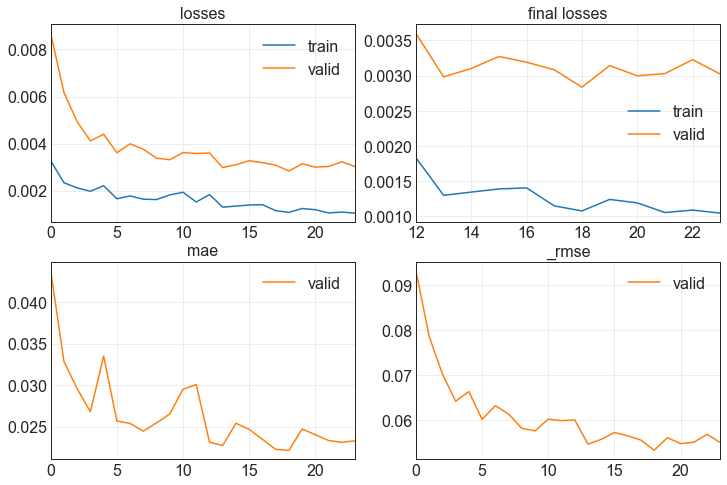

257.5802936553955                                                                                                      
[0.001046102843247354, 0.0030222975183278322, 0.023301763460040092, 0.05497542768716812]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 51%|███████████████████▉                   | 51/100 [1:20:52<1:54:11, 139.83s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 13: early stopping                                                                          
 51%|███████████████████▉                   | 51/100 [1:23:07<1:54:11, 139.83s/trial, best loss: 0.0026584535371512175]

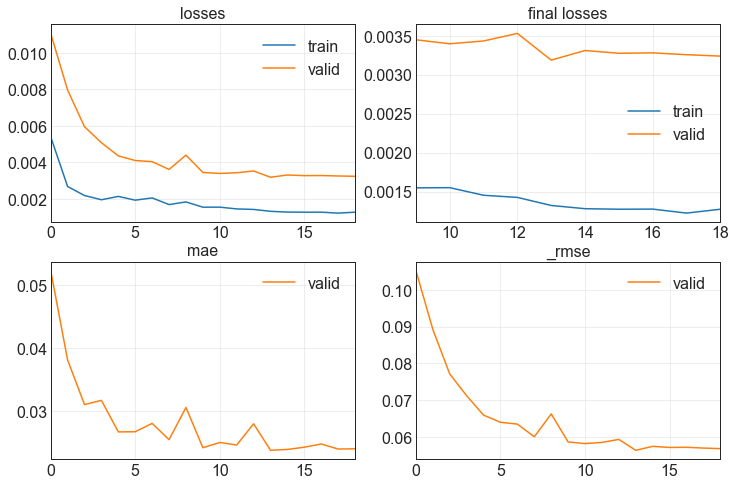

135.7045726776123                                                                                                      
[0.0012723153922706842, 0.0032385054510086775, 0.023988397791981697, 0.05690786615014076]                              
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 52%|████████████████████▎                  | 52/100 [1:23:09<1:51:13, 139.04s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 5: early stopping                                                                           
 52%|████████████████████▎                  | 52/100 [1:24:08<1:51:13, 139.04s/trial, best loss: 0.0026584535371512175]

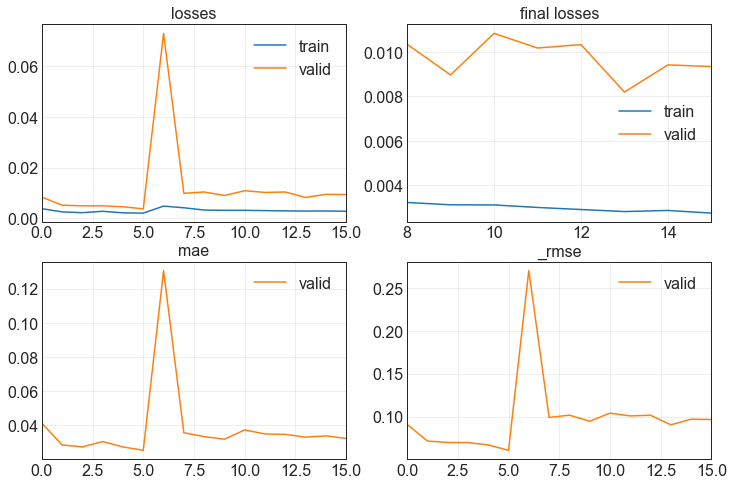

59.596978187561035                                                                                                     
[0.0027484484016895294, 0.00934858713299036, 0.032355908304452896, 0.09668809175491333]                                
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 100, 'lr': 0.1, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 53%|████████████████████▋                  | 53/100 [1:24:10<1:30:36, 115.67s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 12: early stopping                                                                          
 53%|████████████████████▋                  | 53/100 [1:24:21<1:30:36, 115.67s/trial, best loss: 0.0026584535371512175]

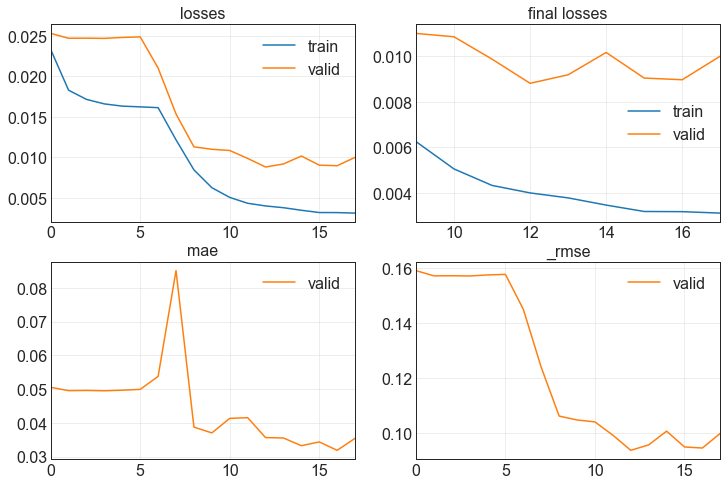

11.122063159942627                                                                                                     
[0.003120190929621458, 0.01001070812344551, 0.03542223945260048, 0.10005352646112442]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 54%|█████████████████████▌                  | 54/100 [1:24:23<1:04:57, 84.73s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 14: early stopping                                                                          
 54%|█████████████████████▌                  | 54/100 [1:27:17<1:04:57, 84.73s/trial, best loss: 0.0026584535371512175]

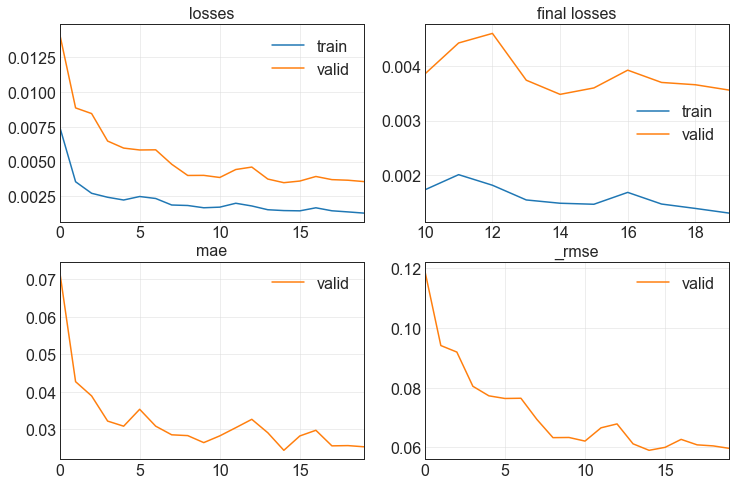

174.38669514656067                                                                                                     
[0.0012954159174114466, 0.003562908386811614, 0.025365160778164864, 0.05969009920954704]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 55%|█████████████████████▍                 | 55/100 [1:27:18<1:24:02, 112.06s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 17: early stopping                                                                          
 55%|█████████████████████▍                 | 55/100 [1:29:21<1:24:02, 112.06s/trial, best loss: 0.0026584535371512175]

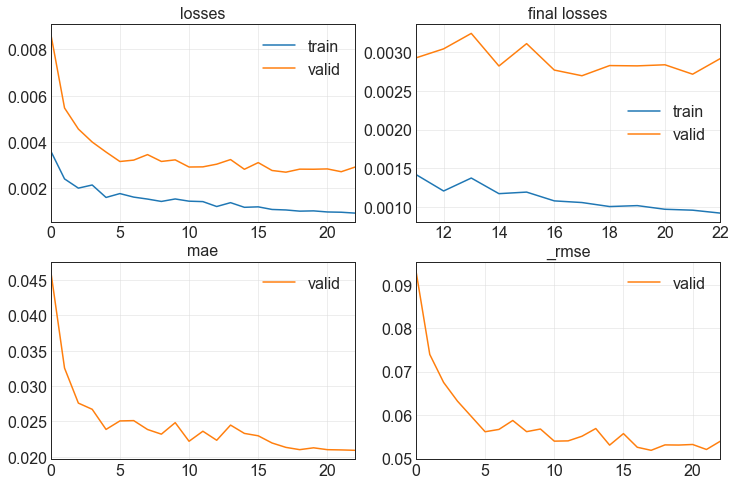

122.72820687294006                                                                                                     
[0.0009241646039299667, 0.002915504854172468, 0.020913016051054, 0.05399540811777115]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 56%|█████████████████████▊                 | 56/100 [1:29:23<1:24:50, 115.69s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 16: early stopping                                                                          
 56%|█████████████████████▊                 | 56/100 [1:30:21<1:24:50, 115.69s/trial, best loss: 0.0026584535371512175]

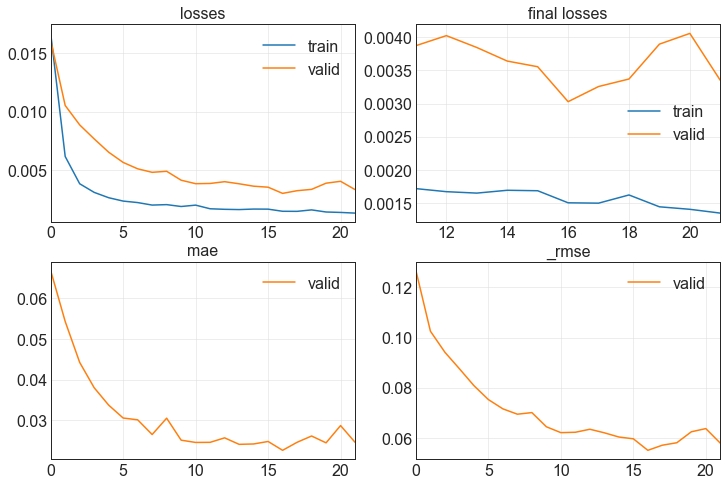

59.116424322128296                                                                                                     
[0.0013479347107931972, 0.0033499752171337605, 0.02460278570652008, 0.057878971099853516]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 16, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 57%|██████████████████████▊                 | 57/100 [1:30:23<1:11:03, 99.16s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 2: early stopping                                                                           
 57%|██████████████████████▊                 | 57/100 [1:31:10<1:11:03, 99.16s/trial, best loss: 0.0026584535371512175]

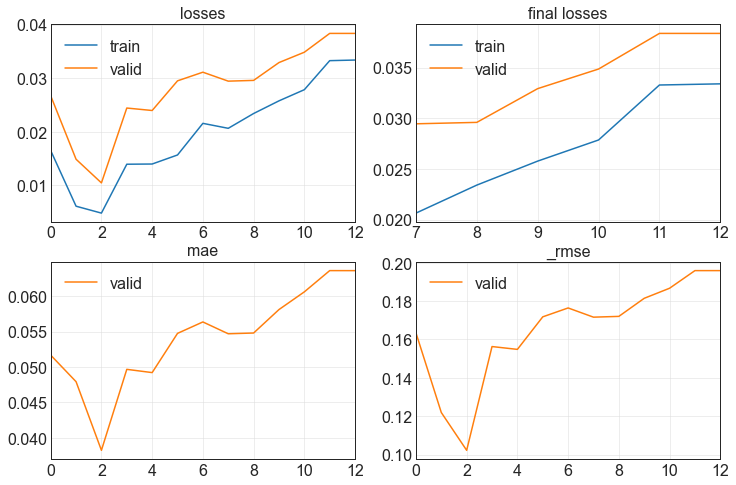

47.48183727264404                                                                                                      
[0.0334010049700737, 0.03837674483656883, 0.06361643224954605, 0.1958998292684555]                                     
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 64, 'epochs': 50, 'lr': 0.001, 'n_heads': 8, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 58%|████████████████████████▎                 | 58/100 [1:31:12<58:51, 84.08s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 22: early stopping                                                                          
 58%|████████████████████████▎                 | 58/100 [1:32:53<58:51, 84.08s/trial, best loss: 0.0026584535371512175]

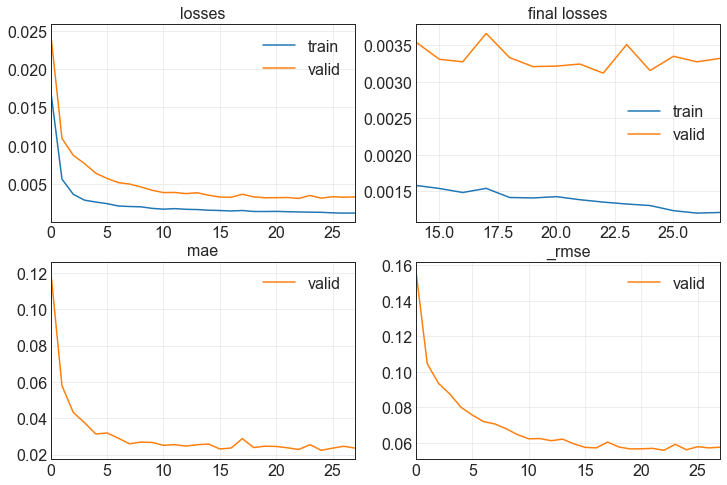

101.13853049278259                                                                                                     
[0.0012127216905355453, 0.003320330288261175, 0.02352166920900345, 0.05762230604887009]                                
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 59%|███████████████████████▌                | 59/100 [1:32:55<1:01:14, 89.62s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 6: early stopping                                                                           
 59%|███████████████████████▌                | 59/100 [1:33:05<1:01:14, 89.62s/trial, best loss: 0.0026584535371512175]

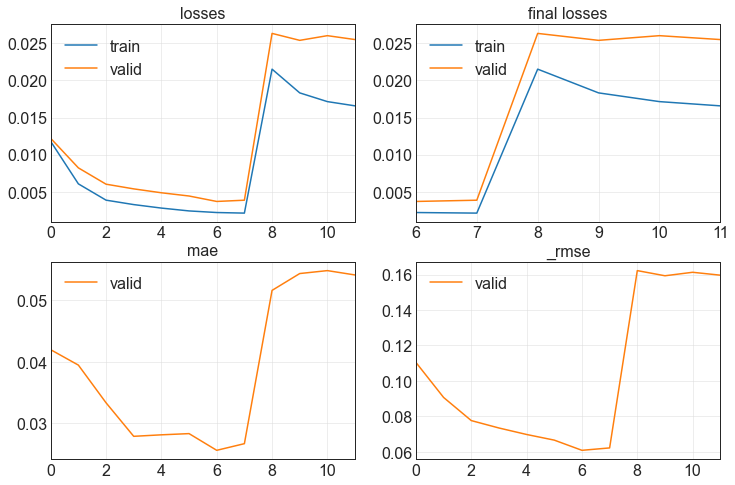

10.297171115875244                                                                                                     
[0.016566138714551926, 0.025484323501586914, 0.054141443222761154, 0.15963810682296753]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 60%|█████████████████████████▏                | 60/100 [1:33:06<44:10, 66.25s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 14: early stopping                                                                          
 60%|█████████████████████████▏                | 60/100 [1:35:26<44:10, 66.25s/trial, best loss: 0.0026584535371512175]

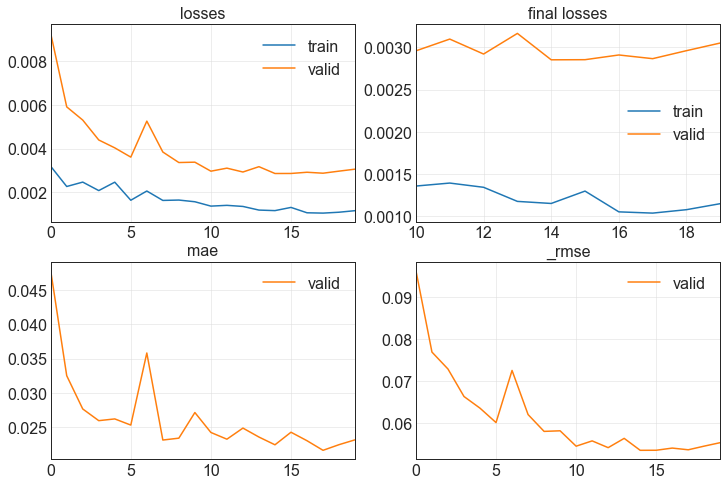

139.60402417182922                                                                                                     
[0.001147810136899352, 0.0030531620141118765, 0.023209189996123314, 0.05525542423129082]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 61%|█████████████████████████▌                | 61/100 [1:35:27<57:38, 88.68s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 24: early stopping                                                                          
 61%|█████████████████████████▌                | 61/100 [1:37:14<57:38, 88.68s/trial, best loss: 0.0026584535371512175]

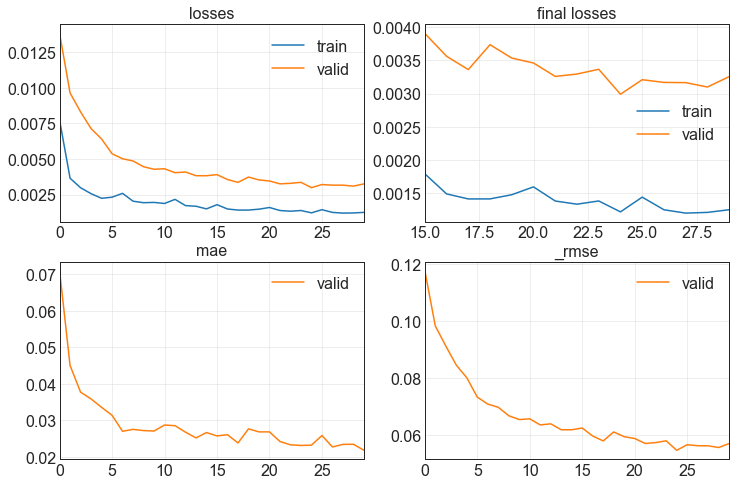

107.30070948600769                                                                                                     
[0.0012523728655651212, 0.0032549635507166386, 0.021758468821644783, 0.05705229192972183]                              
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 4, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 62%|██████████████████████████                | 62/100 [1:37:16<59:58, 94.70s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 20: early stopping                                                                          
 62%|██████████████████████████                | 62/100 [1:38:26<59:58, 94.70s/trial, best loss: 0.0026584535371512175]

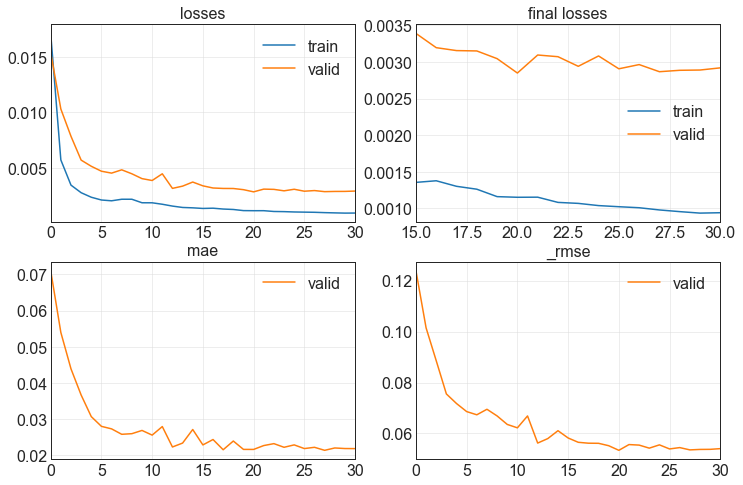

70.47157835960388                                                                                                      
[0.0009419088019058108, 0.002918865066021681, 0.021877724677324295, 0.0540265217423439]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.1, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 63%|██████████████████████████▍               | 63/100 [1:38:28<54:10, 87.86s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 1: early stopping                                                                           
 63%|██████████████████████████▍               | 63/100 [1:39:17<54:10, 87.86s/trial, best loss: 0.0026584535371512175]

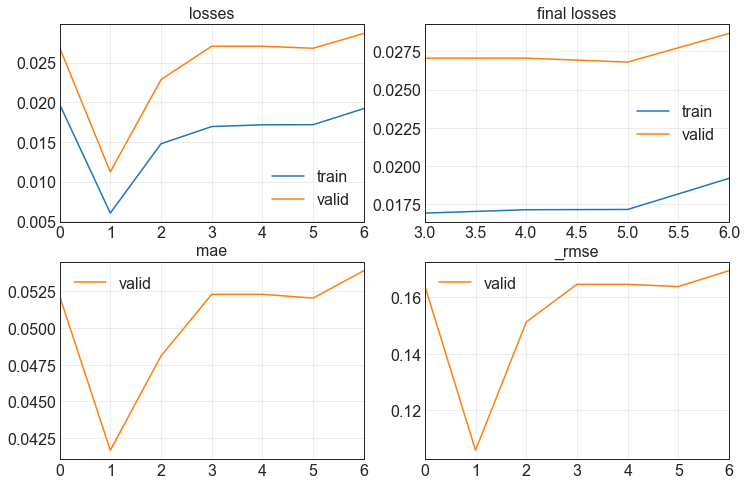

49.09173083305359                                                                                                      
[0.019208470359444618, 0.028669536113739014, 0.05391307920217514, 0.16932080686092377]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 64%|██████████████████████████▉               | 64/100 [1:39:19<45:59, 76.66s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 19: early stopping                                                                          
 64%|██████████████████████████▉               | 64/100 [1:43:36<45:59, 76.66s/trial, best loss: 0.0026584535371512175]

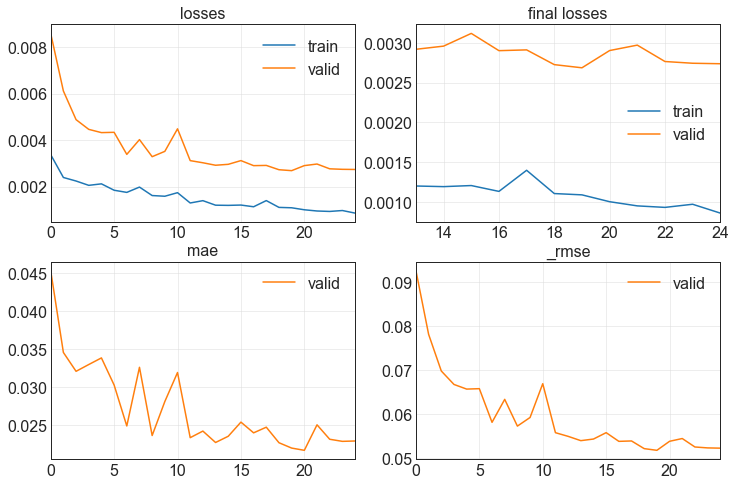

257.69263529777527                                                                                                     
[0.0008576611871831119, 0.002736262744292617, 0.02292768470942974, 0.052309297025203705]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 65%|█████████████████████████▎             | 65/100 [1:43:38<1:16:38, 131.40s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 12: early stopping                                                                          
 65%|█████████████████████████▎             | 65/100 [1:46:43<1:16:38, 131.40s/trial, best loss: 0.0026584535371512175]

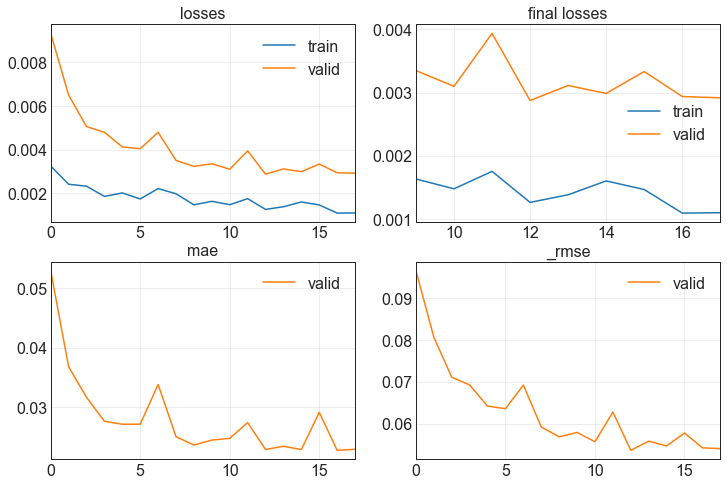

185.39041328430176                                                                                                     
[0.0010964990360662341, 0.002916359808295965, 0.02292773127555847, 0.05400333181023598]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 66%|█████████████████████████▋             | 66/100 [1:46:45<1:23:52, 148.02s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 7: early stopping                                                                           
 66%|█████████████████████████▋             | 66/100 [1:48:58<1:23:52, 148.02s/trial, best loss: 0.0026584535371512175]

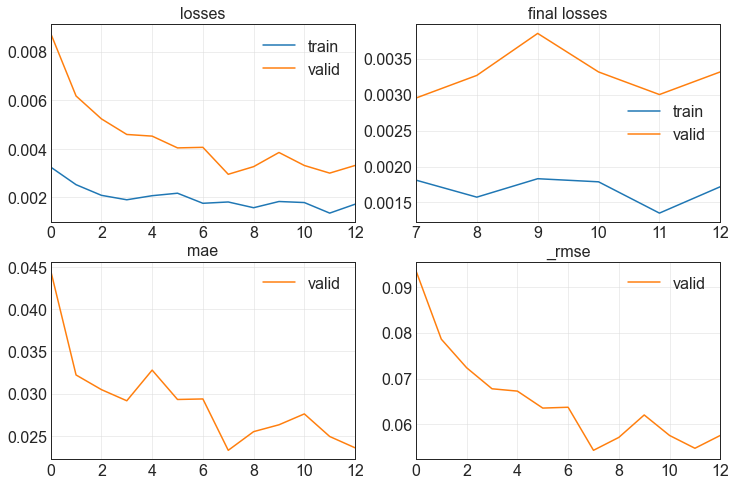

134.26085019111633                                                                                                     
[0.0017191716469824314, 0.00331475050188601, 0.02358982339501381, 0.057573866099119186]                                
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 67%|██████████████████████████▏            | 67/100 [1:49:00<1:19:22, 144.32s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 6: early stopping                                                                           
 67%|██████████████████████████▏            | 67/100 [1:51:04<1:19:22, 144.32s/trial, best loss: 0.0026584535371512175]

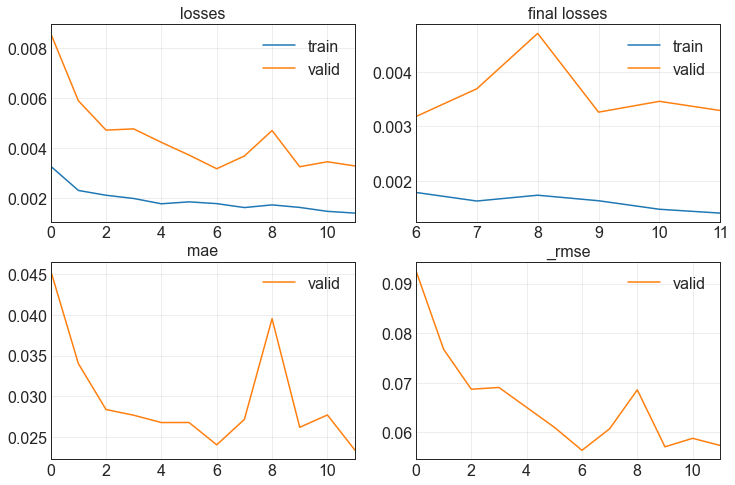

123.9494457244873                                                                                                      
[0.0014114630175754428, 0.003290262771770358, 0.023380950093269348, 0.057360801845788956]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 68%|██████████████████████████▌            | 68/100 [1:51:06<1:13:56, 138.64s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 20: early stopping                                                                          
 68%|██████████████████████████▌            | 68/100 [1:55:33<1:13:56, 138.64s/trial, best loss: 0.0026584535371512175]

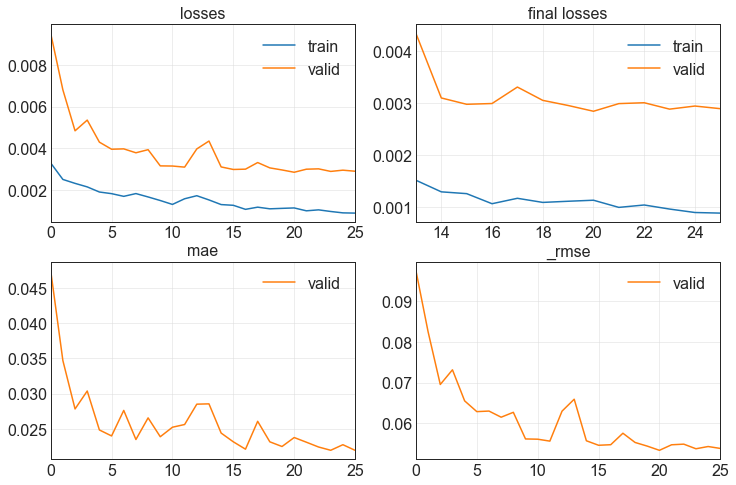

268.1012887954712                                                                                                      
[0.0008906159782782197, 0.0028981005307286978, 0.02196618542075157, 0.053834009915590286]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 69%|██████████████████████████▉            | 69/100 [1:55:35<1:31:55, 177.91s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 17: early stopping                                                                          
 69%|██████████████████████████▉            | 69/100 [1:59:32<1:31:55, 177.91s/trial, best loss: 0.0026584535371512175]

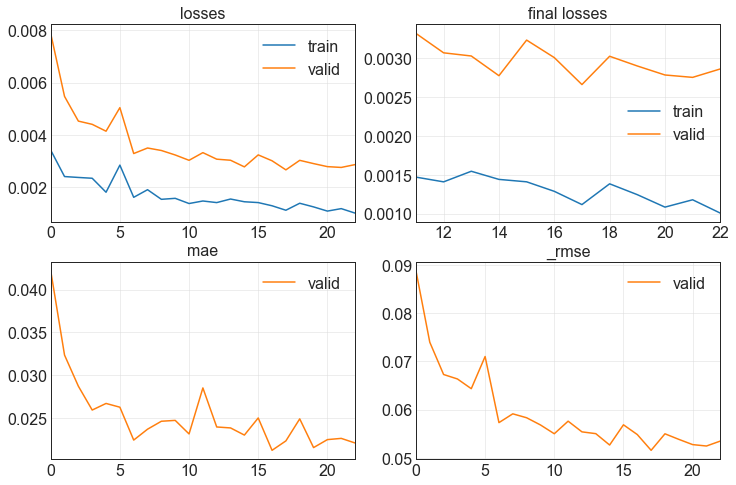

237.2801377773285                                                                                                      
[0.0010060688946396112, 0.0028628187719732523, 0.022104695439338684, 0.0535053089261055]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 70%|███████████████████████████▎           | 70/100 [1:59:34<1:38:04, 196.15s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 12: early stopping                                                                          
 70%|███████████████████████████▎           | 70/100 [2:02:39<1:38:04, 196.15s/trial, best loss: 0.0026584535371512175]

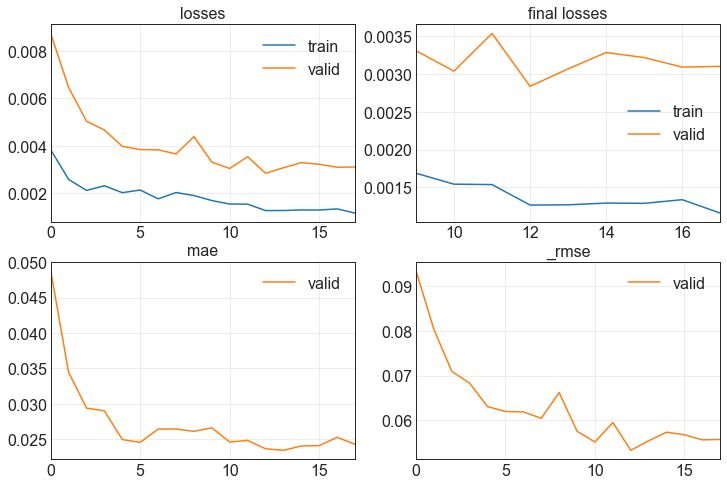

185.62638688087463                                                                                                     
[0.0011573522351682186, 0.003103666240349412, 0.024308525025844574, 0.055710554122924805]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 5, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 71%|███████████████████████████▋           | 71/100 [2:02:41<1:33:29, 193.43s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 13: early stopping                                                                          
 71%|███████████████████████████▋           | 71/100 [2:05:56<1:33:29, 193.43s/trial, best loss: 0.0026584535371512175]

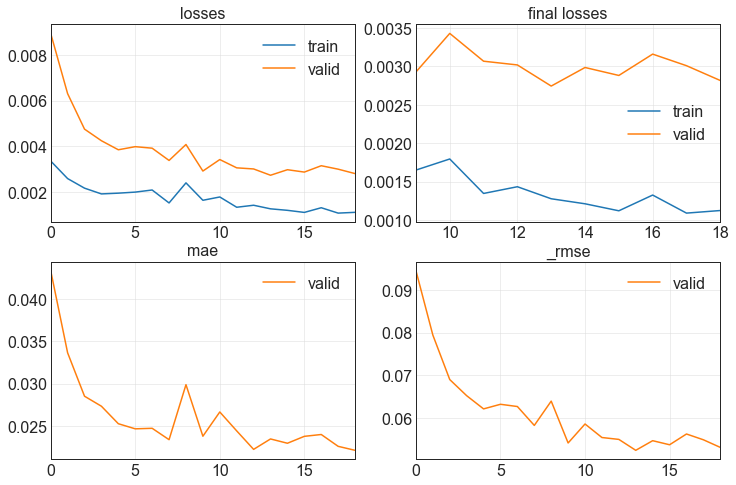

195.72031140327454                                                                                                     
[0.0011248454684391618, 0.0028156470507383347, 0.022094078361988068, 0.053062666207551956]                             
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 72%|████████████████████████████           | 72/100 [2:05:58<1:30:47, 194.55s/trial, best loss: 0.0026584535371512175]

No improvement since epoch 18: early stopping                                                                          
 72%|████████████████████████████           | 72/100 [2:08:06<1:30:47, 194.55s/trial, best loss: 0.0026584535371512175]

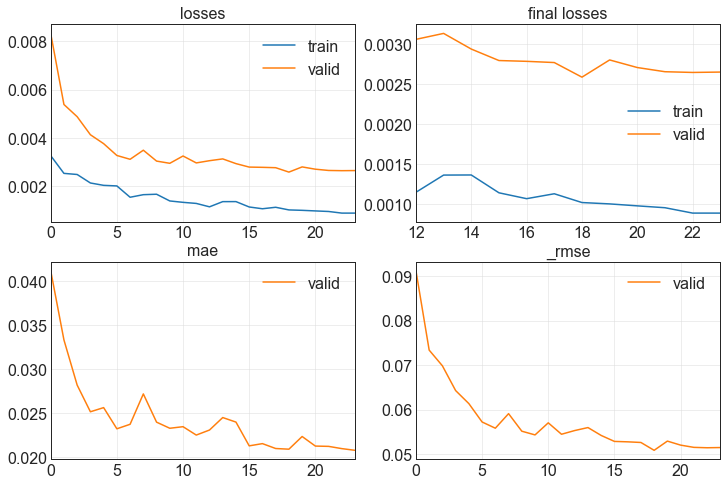

128.28656888008118                                                                                                     
[0.0008863422553986311, 0.0026468634605407715, 0.02073652856051922, 0.05144767835736275]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 73%|████████████████████████████▍          | 73/100 [2:08:08<1:18:47, 175.09s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 17: early stopping                                                                          
 73%|████████████████████████████▍          | 73/100 [2:10:10<1:18:47, 175.09s/trial, best loss: 0.0026468634605407715]

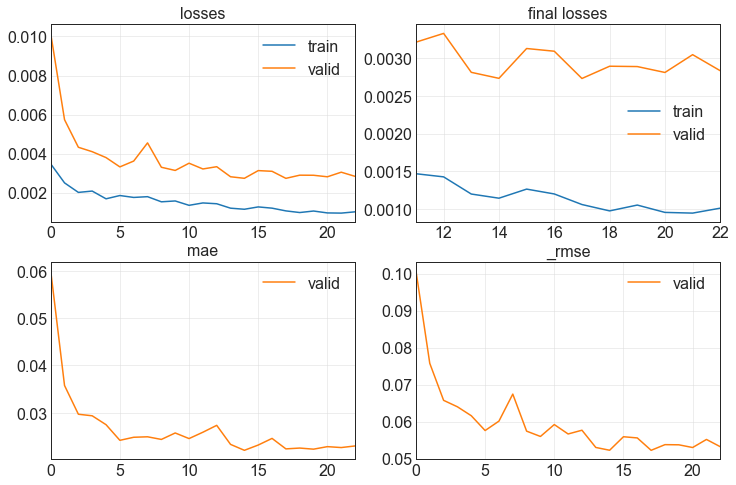

122.45001125335693                                                                                                     
[0.001013453584164381, 0.0028318450786173344, 0.022993402555584908, 0.05321508273482323]                               
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 74%|████████████████████████████▊          | 74/100 [2:10:12<1:09:12, 159.73s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 15: early stopping                                                                          
 74%|████████████████████████████▊          | 74/100 [2:11:10<1:09:12, 159.73s/trial, best loss: 0.0026468634605407715]

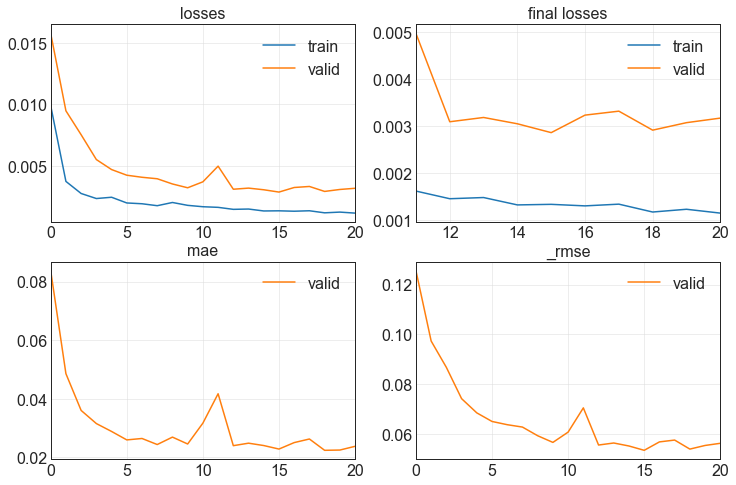

58.49596929550171                                                                                                      
[0.0011461754329502583, 0.0031694762874394655, 0.023757146671414375, 0.05629810318350792]                              
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 75%|██████████████████████████████▊          | 75/100 [2:11:12<54:04, 129.79s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 9: early stopping                                                                           
 75%|██████████████████████████████▊          | 75/100 [2:11:24<54:04, 129.79s/trial, best loss: 0.0026468634605407715]

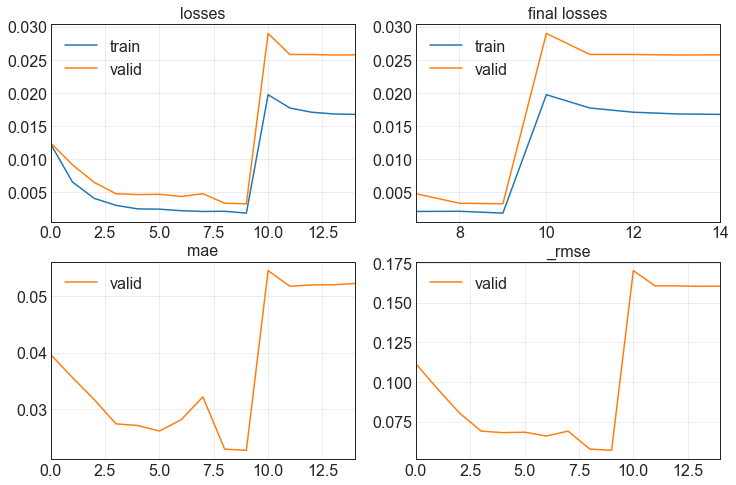

12.745707511901855                                                                                                     
[0.016747048124670982, 0.025734875351190567, 0.05220600217580795, 0.16042093932628632]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 76%|███████████████████████████████▉          | 76/100 [2:11:26<38:02, 95.11s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 16: early stopping                                                                          
 76%|███████████████████████████████▉          | 76/100 [2:13:22<38:02, 95.11s/trial, best loss: 0.0026468634605407715]

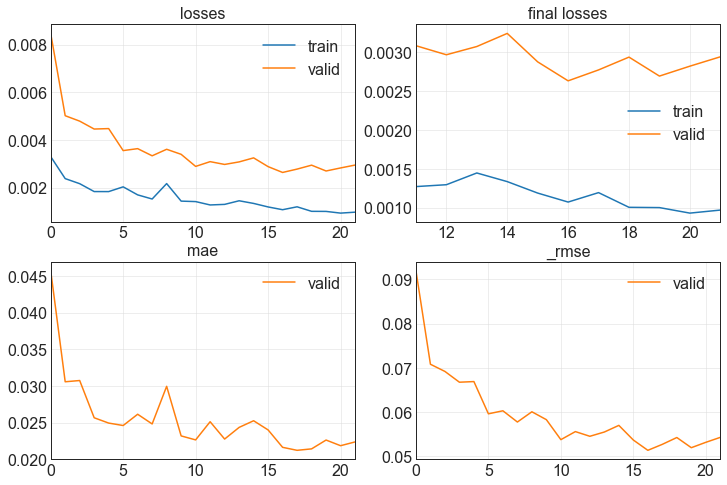

117.00923085212708                                                                                                     
[0.000967673899140209, 0.0029434962198138237, 0.022351570427417755, 0.054253995418548584]                              
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 77%|███████████████████████████████▌         | 77/100 [2:13:24<39:08, 102.10s/trial, best loss: 0.0026468634605407715]

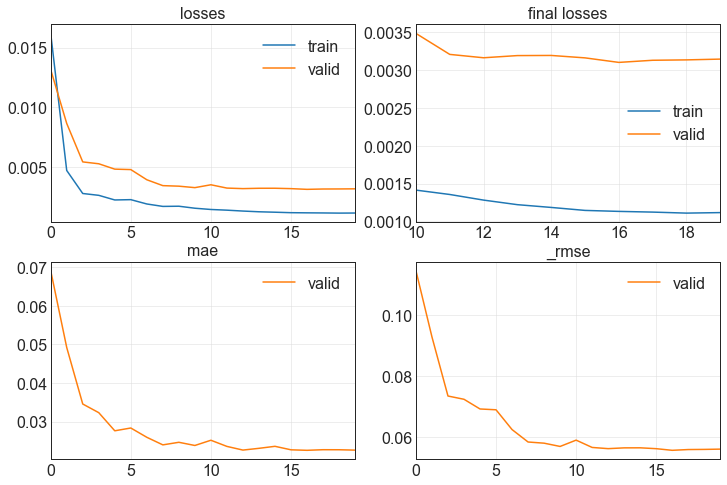

28.981390476226807                                                                                                     
[0.0011170132784172893, 0.0031475333962589502, 0.022605635225772858, 0.05610287934541702]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 78%|████████████████████████████████▊         | 78/100 [2:13:55<29:32, 80.59s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 33: early stopping                                                                          
 78%|████████████████████████████████▊         | 78/100 [2:17:44<29:32, 80.59s/trial, best loss: 0.0026468634605407715]

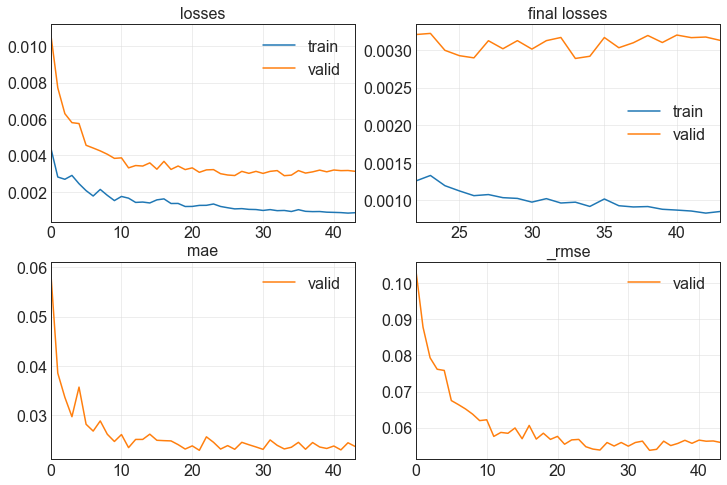

229.99403762817383                                                                                                     
[0.0008526466554030776, 0.003128818003460765, 0.023611022159457207, 0.05593583360314369]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 50, 'lr': 0.1, 'n_heads': 16, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 79%|████████████████████████████████▍        | 79/100 [2:17:46<44:02, 125.84s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 0: early stopping                                                                           
 79%|████████████████████████████████▍        | 79/100 [2:18:26<44:02, 125.84s/trial, best loss: 0.0026468634605407715]

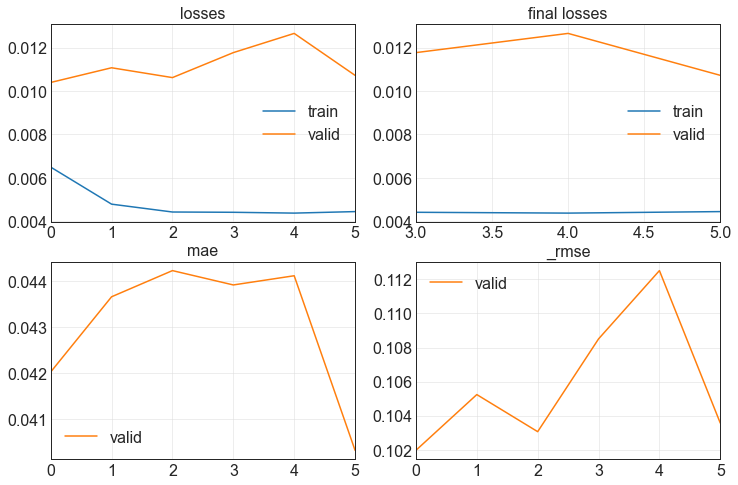

40.926515340805054                                                                                                     
[0.004443877376616001, 0.010725513100624084, 0.04032890871167183, 0.1035640612244606]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 80%|████████████████████████████████▊        | 80/100 [2:18:28<33:35, 100.79s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 3: early stopping                                                                           
 80%|████████████████████████████████▊        | 80/100 [2:18:53<33:35, 100.79s/trial, best loss: 0.0026468634605407715]

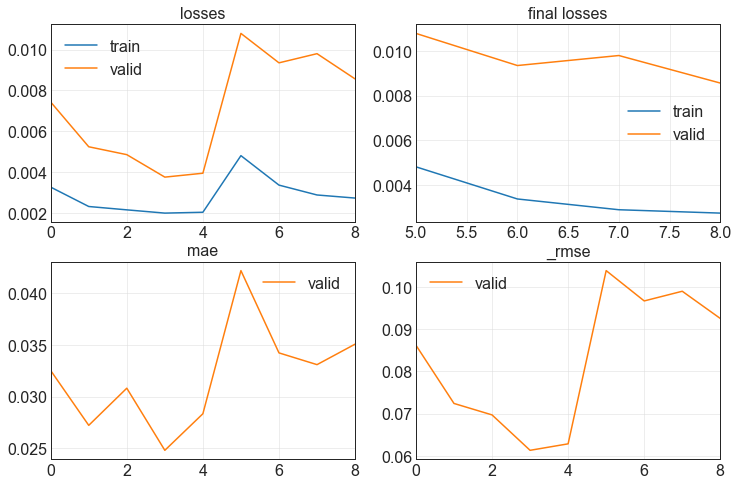

24.808505535125732                                                                                                     
[0.002738828770816326, 0.008562951348721981, 0.03508035093545914, 0.09253621846437454]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 81%|██████████████████████████████████        | 81/100 [2:18:55<24:49, 78.42s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 24: early stopping                                                                          
 81%|██████████████████████████████████        | 81/100 [2:22:24<24:49, 78.42s/trial, best loss: 0.0026468634605407715]

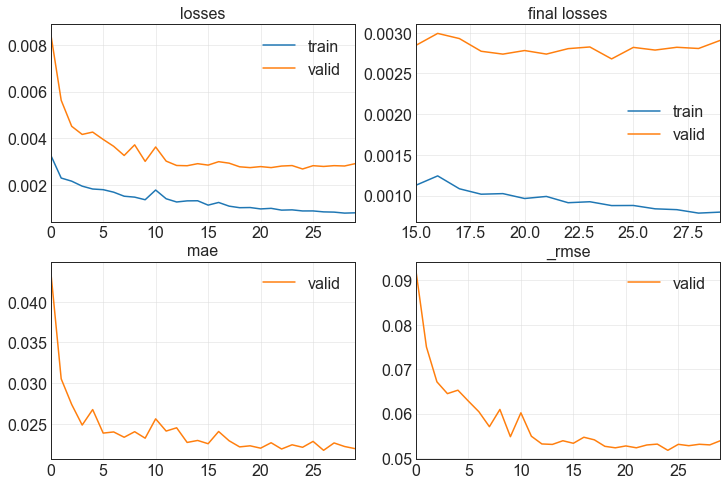

209.6127598285675                                                                                                      
[0.0007972437306307256, 0.002906528301537037, 0.021965941414237022, 0.05391222611069679]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 82%|█████████████████████████████████▌       | 82/100 [2:22:26<35:27, 118.20s/trial, best loss: 0.0026468634605407715]

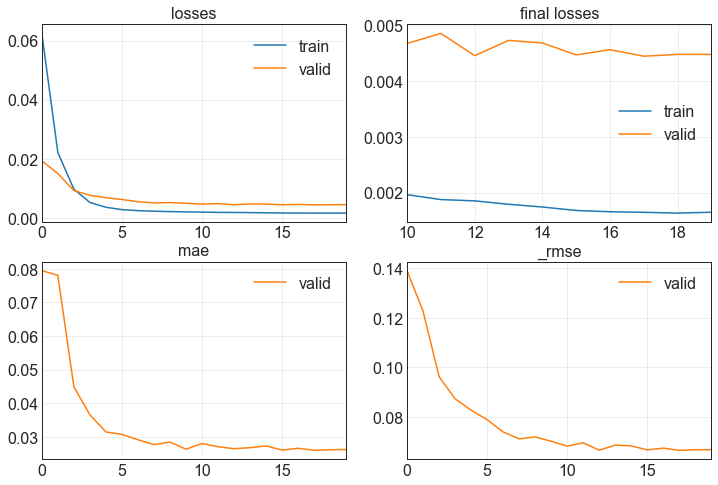

20.63840627670288                                                                                                      
[0.0016500402707606554, 0.004478563088923693, 0.02620035596191883, 0.06692206859588623]                                
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 4, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 83%|██████████████████████████████████▊       | 83/100 [2:22:48<25:19, 89.36s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 20: early stopping                                                                          
 83%|██████████████████████████████████▊       | 83/100 [2:23:46<25:19, 89.36s/trial, best loss: 0.0026468634605407715]

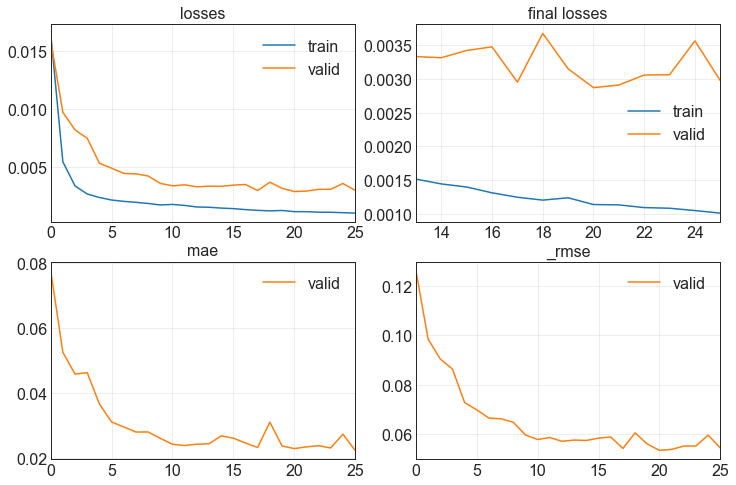

59.18712377548218                                                                                                      
[0.0010098818456754088, 0.002976812422275543, 0.022501179948449135, 0.05456016957759857]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 100, 'lr': 0.1, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 84%|███████████████████████████████████▎      | 84/100 [2:23:48<21:31, 80.73s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 12: early stopping                                                                          
 84%|███████████████████████████████████▎      | 84/100 [2:24:52<21:31, 80.73s/trial, best loss: 0.0026468634605407715]

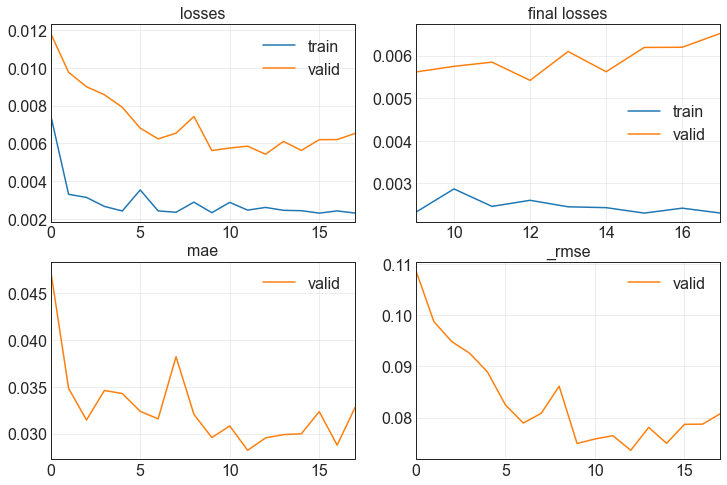

64.61351609230042                                                                                                      
[0.0023057034704834223, 0.006523688789457083, 0.03279491141438484, 0.0807693675160408]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 8, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 85%|███████████████████████████████████▋      | 85/100 [2:24:54<19:04, 76.32s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 5: early stopping                                                                           
 85%|███████████████████████████████████▋      | 85/100 [2:25:52<19:04, 76.32s/trial, best loss: 0.0026468634605407715]

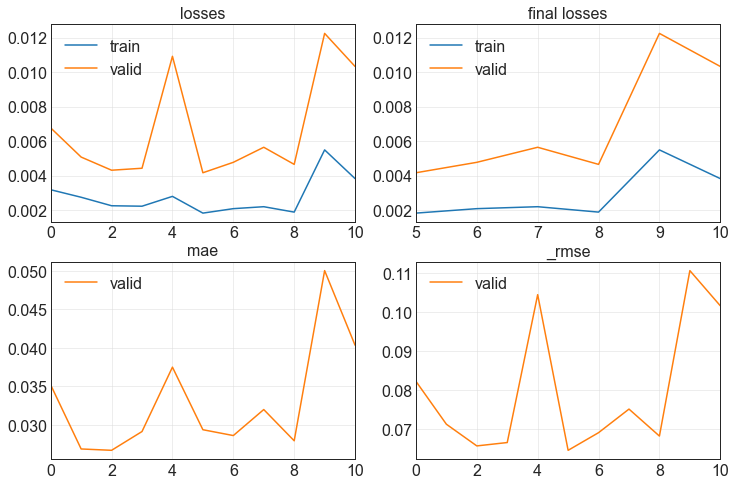

58.697386026382446                                                                                                     
[0.0038280487060546875, 0.010323894210159779, 0.040345486253499985, 0.10160655528306961]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 86%|████████████████████████████████████      | 86/100 [2:25:54<16:40, 71.46s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 20: early stopping                                                                          
 86%|████████████████████████████████████      | 86/100 [2:29:31<16:40, 71.46s/trial, best loss: 0.0026468634605407715]

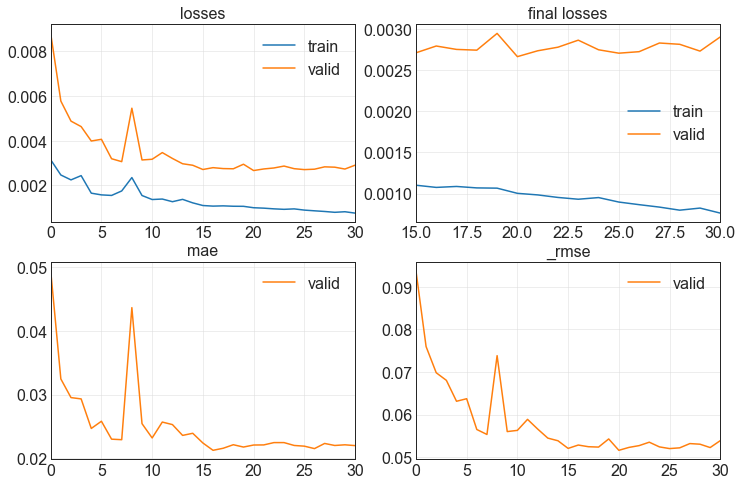

216.62268233299255                                                                                                     
[0.0007621778640896082, 0.0029067080467939377, 0.022010579705238342, 0.053913891315460205]                             
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 87%|███████████████████████████████████▋     | 87/100 [2:29:32<25:00, 115.44s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 16: early stopping                                                                          
 87%|███████████████████████████████████▋     | 87/100 [2:30:50<25:00, 115.44s/trial, best loss: 0.0026468634605407715]

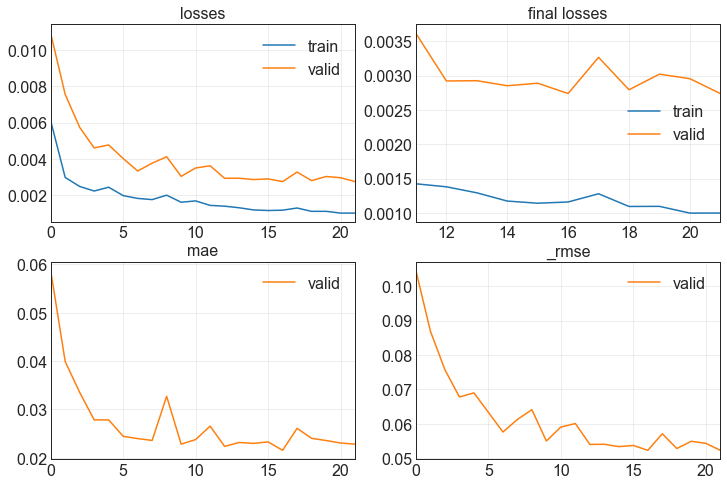

78.41005039215088                                                                                                      
[0.0009999563917517662, 0.0027388588059693575, 0.02281246706843376, 0.05233410373330116]                               
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 128, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 88%|████████████████████████████████████     | 88/100 [2:30:52<20:57, 104.76s/trial, best loss: 0.0026468634605407715]

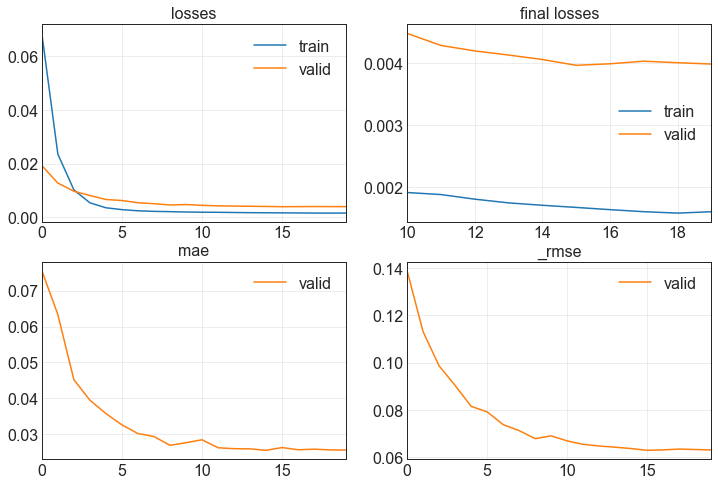

16.22714138031006                                                                                                      
[0.0015961768804118037, 0.003980939742177725, 0.025533607229590416, 0.06309468299150467]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 64, 'epochs': 100, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 89%|█████████████████████████████████████▍    | 89/100 [2:31:10<14:24, 78.63s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 15: early stopping                                                                          
 89%|█████████████████████████████████████▍    | 89/100 [2:33:32<14:24, 78.63s/trial, best loss: 0.0026468634605407715]

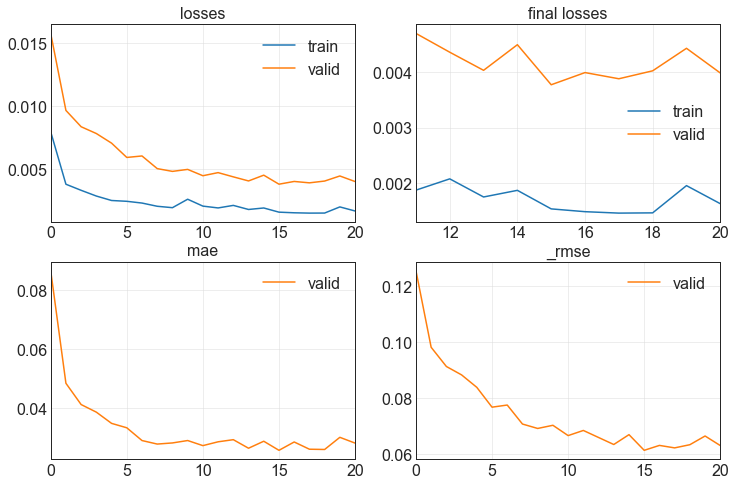

142.62638783454895                                                                                                     
[0.001632323837839067, 0.00398085406050086, 0.02801203541457653, 0.06309400498867035]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 50, 'lr': 0.1, 'n_heads': 8, 'n_layers': 4, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 90%|█████████████████████████████████████▊    | 90/100 [2:33:34<16:22, 98.25s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 5: early stopping                                                                           
 90%|█████████████████████████████████████▊    | 90/100 [2:33:59<16:22, 98.25s/trial, best loss: 0.0026468634605407715]

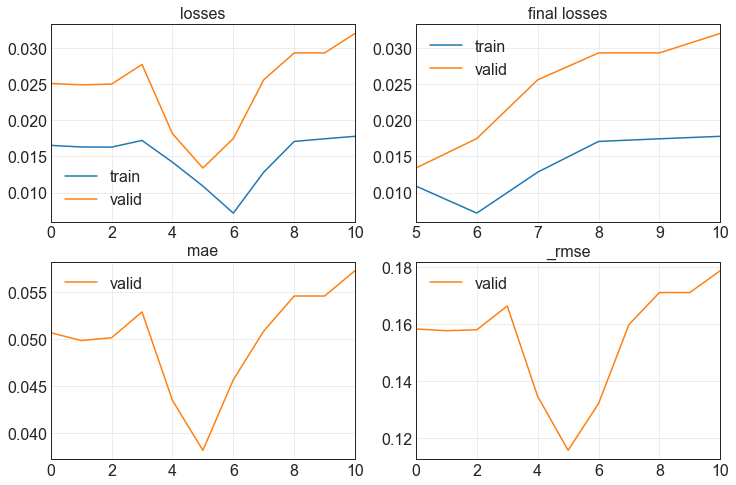

25.320548057556152                                                                                                     
[0.01777125895023346, 0.032002564519643784, 0.057240962982177734, 0.1788926124572754]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 91%|██████████████████████████████████████▏   | 91/100 [2:34:01<11:31, 76.80s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 3: early stopping                                                                           
 91%|██████████████████████████████████████▏   | 91/100 [2:34:51<11:31, 76.80s/trial, best loss: 0.0026468634605407715]

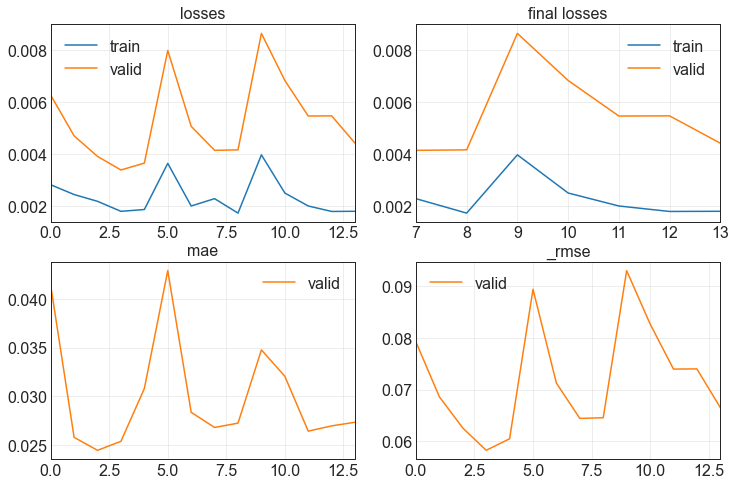

51.06935715675354                                                                                                      
[0.0018049516947939992, 0.004426119849085808, 0.027329688891768456, 0.06652908027172089]                               
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 92%|██████████████████████████████████████▋   | 92/100 [2:34:53<09:16, 69.50s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 10: early stopping                                                                          
 92%|██████████████████████████████████████▋   | 92/100 [2:36:45<09:16, 69.50s/trial, best loss: 0.0026468634605407715]

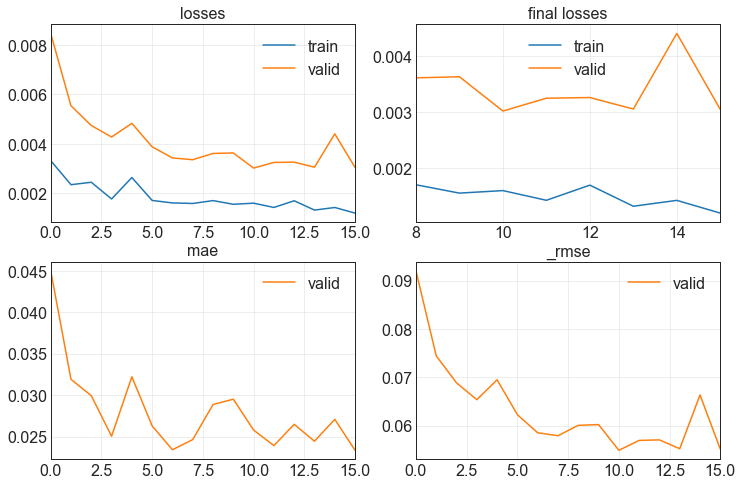

111.9351532459259                                                                                                      
[0.0011911166366189718, 0.0030432248022407293, 0.02333507314324379, 0.055165424942970276]                              
Trying params:                                                                                                         
{'batch_size': 32, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 93%|███████████████████████████████████████   | 93/100 [2:36:47<09:38, 82.66s/trial, best loss: 0.0026468634605407715]

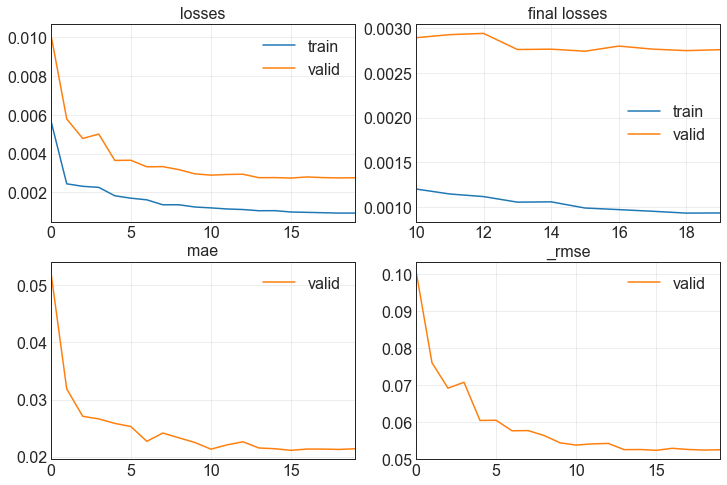

54.61207294464111                                                                                                      
[0.0009363990393467247, 0.0027576342690736055, 0.021372772753238678, 0.052513182163238525]                             
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 128, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 94%|███████████████████████████████████████▍  | 94/100 [2:37:43<07:28, 74.68s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 24: early stopping                                                                          
 94%|███████████████████████████████████████▍  | 94/100 [2:41:08<07:28, 74.68s/trial, best loss: 0.0026468634605407715]

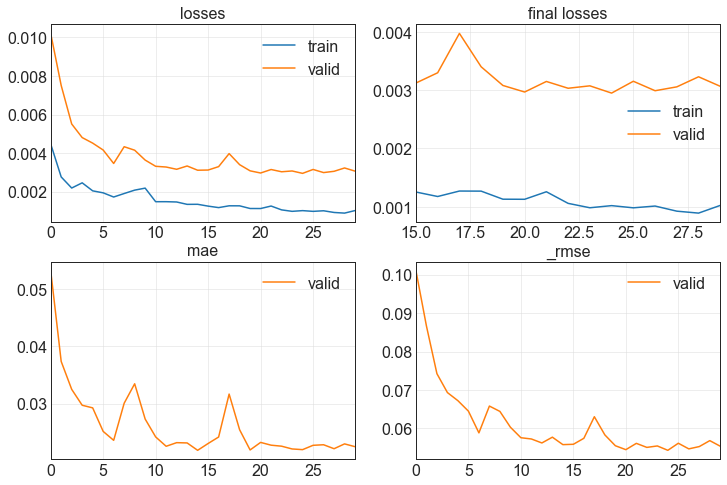

206.03782510757446                                                                                                     
[0.0010231671622022986, 0.0030669504776597023, 0.022465111687779427, 0.05538005009293556]                              
Trying params:                                                                                                         
{'batch_size': 128, 'd_model': 64, 'epochs': 100, 'lr': 0.1, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 10}
TST                                                                                                                    
 95%|██████████████████████████████████████▉  | 95/100 [2:41:10<09:32, 114.51s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 13: early stopping                                                                          
 95%|██████████████████████████████████████▉  | 95/100 [2:41:34<09:32, 114.51s/trial, best loss: 0.0026468634605407715]

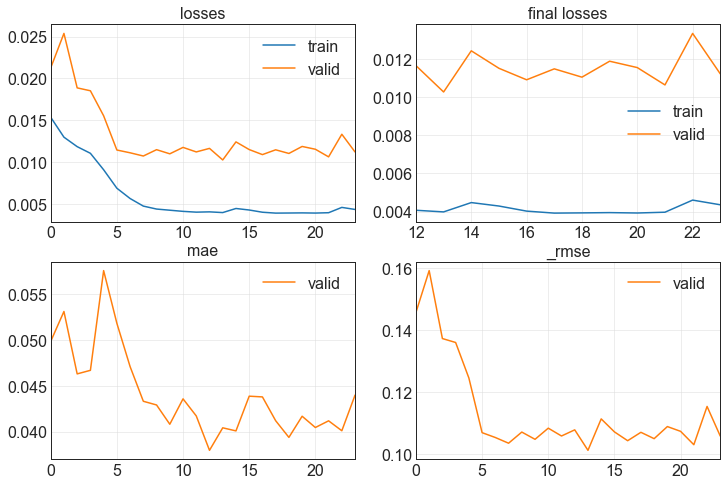

24.097318172454834                                                                                                     
[0.004353330936282873, 0.011211030185222626, 0.04399159550666809, 0.10588214546442032]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 8, 'n_layers': 4, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 96%|████████████████████████████████████████▎ | 96/100 [2:41:36<05:51, 87.82s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 14: early stopping                                                                          
 96%|████████████████████████████████████████▎ | 96/100 [2:44:28<05:51, 87.82s/trial, best loss: 0.0026468634605407715]

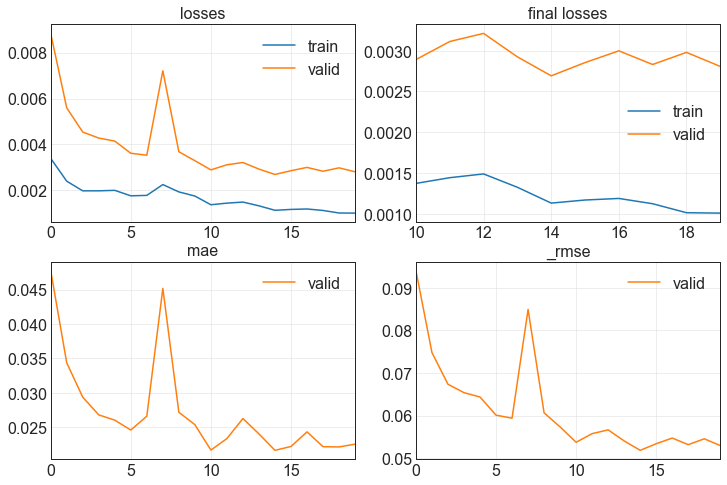

173.04712533950806                                                                                                     
[0.0010075917234644294, 0.0028073277790099382, 0.022543713450431824, 0.05298422649502754]                              
Trying params:                                                                                                         
{'batch_size': 64, 'd_model': 256, 'epochs': 50, 'lr': 0.01, 'n_heads': 32, 'n_layers': 1, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 97%|███████████████████████████████████████▊ | 97/100 [2:44:30<05:41, 113.82s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 10: early stopping                                                                          
 97%|███████████████████████████████████████▊ | 97/100 [2:44:46<05:41, 113.82s/trial, best loss: 0.0026468634605407715]

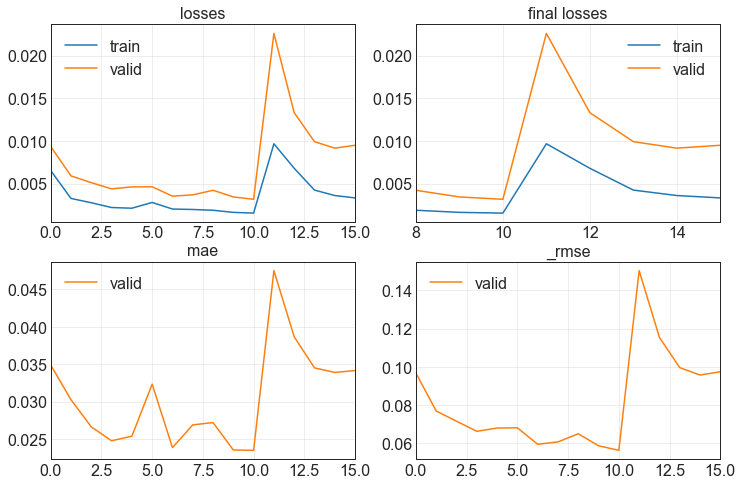

16.6272931098938                                                                                                       
[0.003339602379128337, 0.00949789583683014, 0.034154802560806274, 0.097457155585289]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 98%|█████████████████████████████████████████▏| 98/100 [2:44:48<02:50, 85.08s/trial, best loss: 0.0026468634605407715]

No improvement since epoch 20: early stopping                                                                          
 98%|█████████████████████████████████████████▏| 98/100 [2:47:06<02:50, 85.08s/trial, best loss: 0.0026468634605407715]

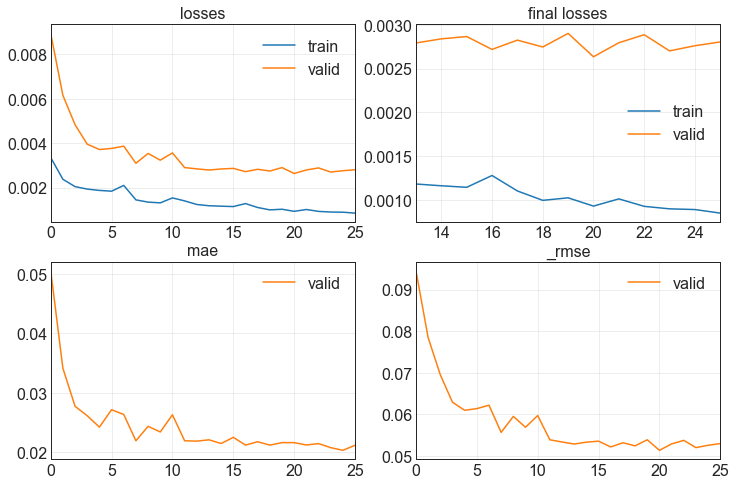

138.33540105819702                                                                                                     
[0.0008500346448272467, 0.0028039105236530304, 0.021194251254200935, 0.05295196548104286]                              
Trying params:                                                                                                         
{'batch_size': 16, 'd_model': 256, 'epochs': 20, 'lr': 0.001, 'n_heads': 32, 'n_layers': 3, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}
TST                                                                                                                    
 99%|████████████████████████████████████████▌| 99/100 [2:47:08<01:41, 101.48s/trial, best loss: 0.0026468634605407715]

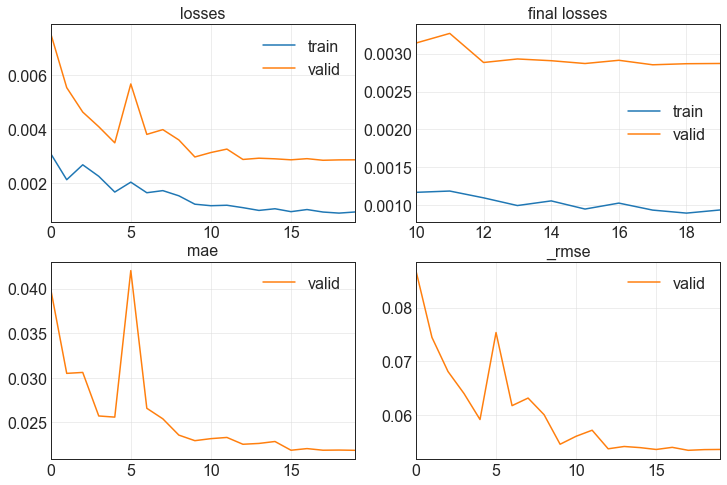

139.41692352294922                                                                                                     
[0.0009383541764691472, 0.0028696174267679453, 0.0218622125685215, 0.05356881022453308]                                
100%|████████████████████████████████████████| 100/100 [2:49:27<00:00, 101.68s/trial, best loss: 0.0026468634605407715]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 16, 'd_model': 256, 'epochs': 50, 'lr': 0.001, 'n_heads': 16, 'n_layers': 2, 'optimizer': <function Adam at 0x000001AA3B4335E8>, 'patience': 5}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(8606, 529, 10)

In [62]:
y.shape

(8606, 529)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = TST
k = {
    'n_layers': params['n_layers'],
    'd_model': params['d_model'],
    'n_heads': params['n_heads']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

TST


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): TST(
    (W_P): Linear(in_features=529, out_features=256, bias=True)
    (res_dropout): Dropout(p=0.1, inplace=False)
    (encoder): _TSTEncoder(
      (layers): ModuleList(
        (0): _TSTEncoderLayer(
          (self_attn): _MultiHeadAttention(
            (W_Q): Linear(in_features=256, out_features=256, bias=False)
            (W_K): Linear(in_features=256, out_features=256, bias=False)
            (W_V): Linear(in_features=256, out_features=256, bias=False)
            (W_O): Linear(in_features=256, out_features=256, bias=False)
          )
          (dropout_attn): Dropout(p=0.1, inplace=False)
          (batchnorm_attn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (ff): Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): GELU()
            (2): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout_ffn): Dropout(p=0.1, inplace=False)
     

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

2,280,545 total parameters.
2,280,545 training parameters.


Training the model:

No improvement since epoch 30: early stopping


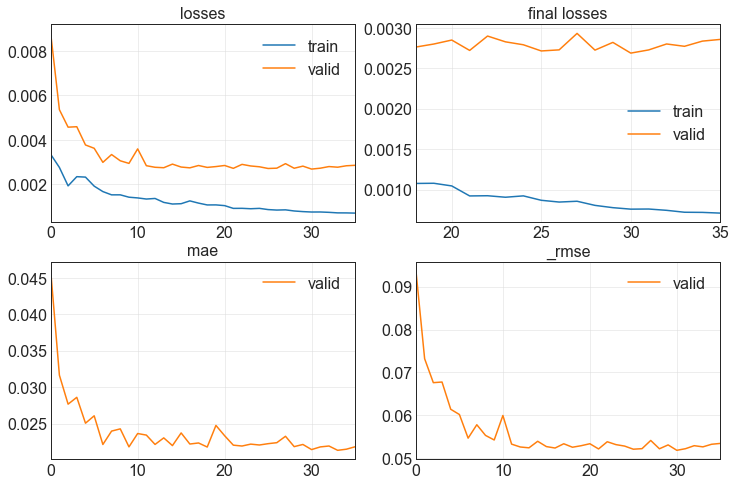

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

2153


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0043, 0.0279, 0.0080,  ..., 0.0014, 0.0013, 0.0012],
         [0.0035, 0.0293, 0.0095,  ..., 0.0013, 0.0014, 0.0012],
         [0.0038, 0.0256, 0.0099,  ..., 0.0013, 0.0012, 0.0011],
         ...,
         [0.0022, 0.0233, 0.0181,  ..., 0.0013, 0.0019, 0.0011],
         [0.0024, 0.0245, 0.0211,  ..., 0.0016, 0.0022, 0.0011],
         [0.0026, 0.0242, 0.0240,  ..., 0.0015, 0.0023, 0.0011]]),
 tensor([[0.0000e+00, 4.2537e-04, 9.6929e-04,  ..., 4.5983e-04, 1.2533e-04,
          0.0000e+00],
         [0.0000e+00, 1.6241e-04, 3.8517e-04,  ..., 5.4193e-04, 8.0880e-05,
          0.0000e+00],
         [0.0000e+00, 2.2912e-04, 1.9301e-03,  ..., 4.0765e-04, 1.9965e-04,
          0.0000e+00],
         ...,
         [0.0000e+00, 4.7334e-03, 0.0000e+00,  ..., 1.2775e-03, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 6.2943e-03, 0.0000e+00,  ..., 1.1132e-03, 2.1495e-04,
          0.0000e+00],
         [0.0000e+00, 1.3714e-02, 0.0000e+00,  ..., 1.7625e-04, 0.0000e+00,
         

In [73]:
test_targets.shape

torch.Size([2153, 529])

In [74]:
test_preds.shape

torch.Size([2153, 529])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(2153, 1, 529)

In [78]:
y_pred.shape

(2153, 1, 529)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(2153, 1, 529)

In [83]:
y_pred.shape

(2153, 1, 529)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  192.86641025543213
Test time (in seconds):  0.7147762775421143


In [92]:
print('Training time (in seconds) per epoch: ', 192.86641025543213 / 36)

Training time (in seconds) per epoch:  5.357400284873115


Calculate the RMSE and MAE for differnt time steps:

In [88]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  15.181736273353023
MAE:  5.189390283113842


Plot the RMSE and MAE distributions for each time step:

In [89]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [90]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

TST_TM-minmax_RMSE-10-1-step-1.pdf
TST_TM-minmax_MAE-10-1-step-1.pdf


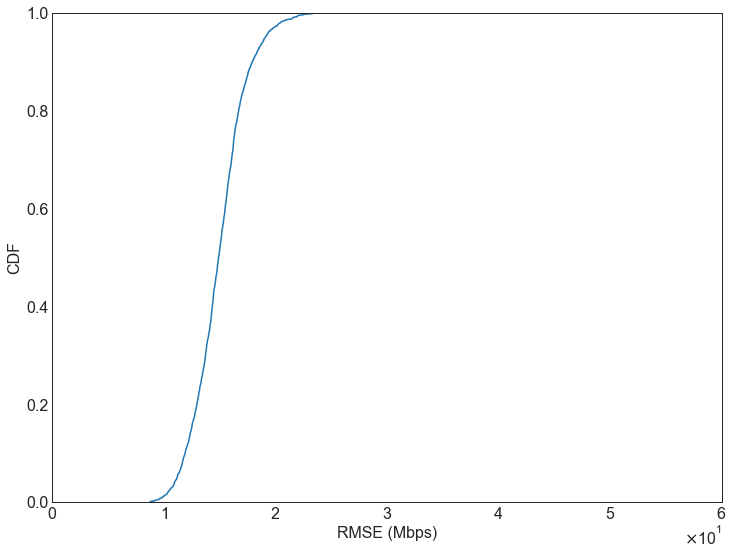

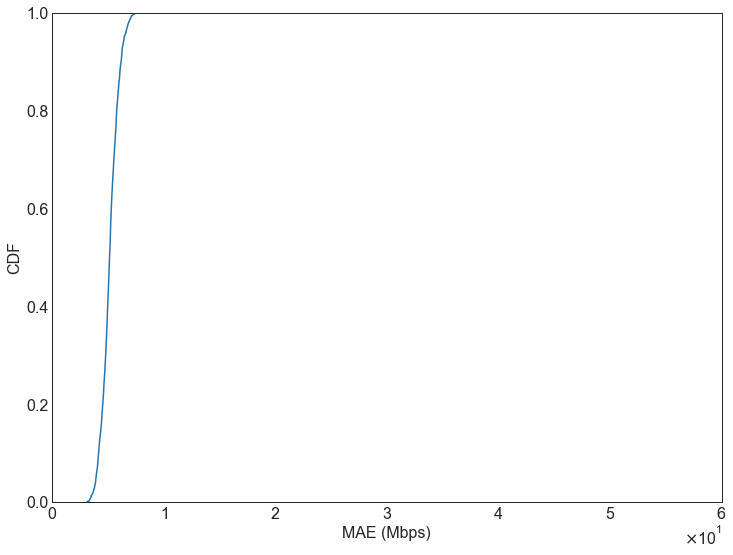

In [91]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)